#This implementation uses fully convolutional and high-resolution networks for Publay Dataset Segmentation in JPEG domain.


* Image used in this implementaion is a DCT transformed image for input image and RGB masked image of the dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob
import numpy as np # linear algebra
import cv2
import matplotlib.pyplot as plt
from matplotlib import image
%matplotlib inline
from sklearn.model_selection import train_test_split
from google.colab import files
from sklearn.metrics import average_precision_score
import keras

In [ ]:
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from keras.models import model_from_json
from keras import activations
from keras.metrics import BinaryAccuracy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

In [ ]:
#paths of images and mask
mask_path = '/content/drive/MyDrive/mask4/'
path = "/content/drive/MyDrive"
dct_path = "/content/drive/MyDrive/publay_dct/"

IMG_HEIGHT, IMG_WIDTH = 256,256
batch_size = 16
seed = 1111

In [ ]:
dct_ids = os.listdir(dct_path)
mask_ids = os.listdir(mask_path)
train_dct_ids, val_dct_ids, train_mask_ids, val_mask_ids = train_test_split(dct_ids, mask_ids, test_size = 0.15)
print(len(dct_ids),len(mask_ids))
print(len(train_dct_ids),len(train_mask_ids))

4746 4746
4034 4034


In [ ]:
class DCT_DataGen(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels=None, batch_size=32, dim=(256,256), n_channels=4,
                 n_classes=4, shuffle=False):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.output_channels = output_channels
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        labels_temp = [self.labels[k] for k in indexes]

        # Generate data
        X, Y= self.__data_generation(list_IDs_temp, labels_temp)

        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp, labels_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        Y = np.empty((self.batch_size, *self.dim, self.n_classes))

        # Generate data
        for i, (ID, label) in enumerate(zip(list_IDs_temp, labels_temp)):
            # Store sample
            X[i,] = np.load("/content/drive/MyDrive/publay_dct/" + ID)
            img = cv2.imread('/content/drive/MyDrive/mask4/' + label)
            Y[i,] = to_categorical(cv2.resize(img, self.dim)[:,:,2], num_classes= self.n_classes

        return X, Y

In [ ]:
train_dct_gen = DCT_DataGen(train_dct_ids, train_mask_ids)
val_dct_gen = DCT_DataGen(val_dct_ids, val_mask_ids)

In [ ]:
image_gen_train = ImageDataGenerator(horizontal_flip=True, validation_split=0.15)

train_image_generator = image_gen_train.flow_from_directory(
    path,
    classes=['publaynet'],
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode= None,
    seed=seed,
    subset='training')

train_mask_generator = image_gen_train.flow_from_directory(
    path,
    classes=['mask'],
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode= None,
    seed=seed,
    subset='training')

train_gen = zip(train_image_generator, train_mask_generator)


Found 4035 images belonging to 1 classes.
Found 4035 images belonging to 1 classes.


In [ ]:
train_image_generator.next().shape

(16, 256, 256, 3)

In [ ]:
validation_image_generator = image_gen_train.flow_from_directory(
    path,
    classes=['publaynet'],
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode=None,
    seed=seed,
    subset='validation') 


validation_mask_generator = image_gen_train.flow_from_directory(
    path,
    classes=['mask'],
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode=None,
    seed=seed,
    subset='validation') 

validation_gen = zip(validation_image_generator, validation_mask_generator)

Found 711 images belonging to 1 classes.
Found 711 images belonging to 1 classes.


In [ ]:
#Function to fill output image with a specific class color
def coloring(main_image,color,mask):
  masking_arr = mask>0.5
  main_image[masking_arr] = np.flipud(color)
  return main_image

#Function to convert the binary masks back into a single colored mask image :  binary mask with 2 channels (text & non-text) -> colored mask image
def output_debinarisation(mask):

  main_image = np.full((mask.shape[0],mask.shape[1],3),255)

  main_image = coloring(main_image,(255,0,0),mask[:,:,1])
  main_image = coloring(main_image,(1,1,1),mask[:,:,0])
  main_image = coloring(main_image,(0,253,0),mask[:,:,2])
  main_image = coloring(main_image,(0,0,255),mask[:,:,3])
  return main_image

In [ ]:
#figure to show the rgb_image,dct_image and the binary masks
fig, ax = plt.subplots(1,5, figsize = (300,300))
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[2].set_xticks([])
ax[3].set_xticks([])
ax[4].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])
ax[2].set_yticks([])
ax[3].set_yticks([])
ax[4].set_yticks([])
ax[0].imshow(x_rgb_data[0])
ax[1].imshow(x_data[0])
ax[2].imshow(output_debinarisation(y_data[0]))
ax[3].imshow(y_data[0,:,:,0],cmap='gray')
ax[4].imshow(y_data[0,:,:,1],cmap='gray')
ax[0].set_title("Input (JPEG Compressed)")
ax[1].set_title("Input (DCT domain)")
ax[2].set_title("Ground truth")
ax[3].set_title("Ground Truth mask of images")
ax[4].set_title("Ground truth mask of text")
plt.show()

NameError: ignored

Error in callback <function flush_figures at 0x7fd0c07dd0e0> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
#High Resolution Network (HR-Net)

def conv3x3(x, out_filters, strides=(1, 1)):
    x = Conv2D(out_filters, 3, padding='same', strides=strides, use_bias=False, kernel_initializer='he_normal')(x)
    return x


def basic_Block(input, out_filters, strides=(1, 1), with_conv_shortcut=False):
    x = conv3x3(input, out_filters, strides)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
 
    x = conv3x3(x, out_filters)
    x = BatchNormalization(axis=3)(x)

    if with_conv_shortcut:
        residual = Conv2D(out_filters, 1, strides=strides, use_bias=False, kernel_initializer='he_normal')(input)
        residual = BatchNormalization(axis=3)(residual)
        x = add([x, residual])
    else:
        x = add([x, input])

    x = Activation('relu')(x)
    return x


def bottleneck_Block(input, out_filters, strides=(1, 1), with_conv_shortcut=False):
    expansion = 4
    de_filters = int(out_filters / expansion)

    x = Conv2D(de_filters, 1, use_bias=False, kernel_initializer='he_normal')(input)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = Conv2D(de_filters, 3, strides=strides, padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = Conv2D(out_filters, 1, use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)

    if with_conv_shortcut:
        residual = Conv2D(out_filters, 1, strides=strides, use_bias=False, kernel_initializer='he_normal')(input)
        residual = BatchNormalization(axis=3)(residual)
        x = add([x, residual])
    else:
        x = add([x, input])

    x = Activation('relu')(x)
    return x


def stem_net(input):
    x = Conv2D(64, 4, strides=(1, 1), padding='same', use_bias=False, kernel_initializer='he_normal')(input)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = bottleneck_Block(x, 256, with_conv_shortcut=True)
    x = bottleneck_Block(x, 256, with_conv_shortcut=False)
    x = bottleneck_Block(x, 256, with_conv_shortcut=False)
    x = bottleneck_Block(x, 256, with_conv_shortcut=False)

    return x


def transition_layer1(x, out_filters_list=[32, 64]):
    x0 = Conv2D(out_filters_list[0], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x0 = BatchNormalization(axis=3)(x0)
    x0 = Activation('relu')(x0)

    x1 = Conv2D(out_filters_list[1], 3, strides=(2, 2),
                padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x1 = BatchNormalization(axis=3)(x1)
    x1 = Activation('relu')(x1)

    return [x0, x1]


def make_branch1_0(x, out_filters=32):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch1_1(x, out_filters=64):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def fuse_layer1(x):
    x0_0 = x[0]
    x0_1 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[1])
    x0_1 = BatchNormalization(axis=3)(x0_1)
    x0_1 = UpSampling2D(size=(2, 2))(x0_1)
    x0 = add([x0_0, x0_1])

    x1_0 = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x1_0 = BatchNormalization(axis=3)(x1_0)
    x1_1 = x[1]
    x1 = add([x1_0, x1_1])
    return [x0, x1]


def transition_layer2(x, out_filters_list=[32, 64, 128]):
    x0 = Conv2D(out_filters_list[0], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x0 = BatchNormalization(axis=3)(x0)
    x0 = Activation('relu')(x0)

    x1 = Conv2D(out_filters_list[1], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x1 = BatchNormalization(axis=3)(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv2D(out_filters_list[2], 3, strides=(2, 2),
                padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x2 = BatchNormalization(axis=3)(x2)
    x2 = Activation('relu')(x2)

    return [x0, x1, x2]


def make_branch2_0(x, out_filters=32):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch2_1(x, out_filters=64):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch2_2(x, out_filters=128):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def fuse_layer2(x):
    x0_0 = x[0]
    x0_1 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[1])
    x0_1 = BatchNormalization(axis=3)(x0_1)
    x0_1 = UpSampling2D(size=(2, 2))(x0_1)
    x0_2 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[2])
    x0_2 = BatchNormalization(axis=3)(x0_2)
    x0_2 = UpSampling2D(size=(4, 4))(x0_2)
    x0 = concatenate([x0_0, x0_1, x0_2], axis=-1)
    return [x0]


def transition_layer3(x, out_filters_list=[32, 64, 128, 256]):
    x0 = Conv2D(out_filters_list[0], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x0 = BatchNormalization(axis=3)(x0)
    x0 = Activation('relu')(x0)

    x1 = Conv2D(out_filters_list[1], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x1 = BatchNormalization(axis=3)(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv2D(out_filters_list[2], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[2])
    x2 = BatchNormalization(axis=3)(x2)
    x2 = Activation('relu')(x2)

    x3 = Conv2D(out_filters_list[3], 3, strides=(2, 2),
                padding='same', use_bias=False, kernel_initializer='he_normal')(x[2])
    x3 = BatchNormalization(axis=3)(x3)
    x3 = Activation('relu')(x3)

    return [x0, x1, x2, x3]


def make_branch3_0(x, out_filters=32):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch3_1(x, out_filters=64):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch3_2(x, out_filters=128):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch3_3(x, out_filters=256):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def fuse_layer3(x):
    x0_0 = x[0]
    x0_1 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[1])
    x0_1 = BatchNormalization(axis=3)(x0_1)
    x0_1 = UpSampling2D(size=(2, 2))(x0_1)
    x0_2 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[2])
    x0_2 = BatchNormalization(axis=3)(x0_2)
    x0_2 = UpSampling2D(size=(4, 4))(x0_2)
    x0_3 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[3])
    x0_3 = BatchNormalization(axis=3)(x0_3)
    x0_3 = UpSampling2D(size=(8, 8))(x0_3)
    x0 = concatenate([x0_0, x0_1, x0_2, x0_3], axis=-1)
    return x0


def final_layer(x, classes=1):
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(classes, 1, use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('sigmoid', name='Classification')(x)
    return x


def seg_hrnet(height, width, channel, classes):
    inputs = Input(shape = (height, width, channel))

    x = stem_net(inputs)

    x = transition_layer1(x)
    x0 = make_branch1_0(x[0])
    x1 = make_branch1_1(x[1])
    x = fuse_layer1([x0, x1])

    x = transition_layer2(x)
    x0 = make_branch2_0(x[0])
    x1 = make_branch2_1(x[1])
    x2 = make_branch2_2(x[2])
    x = fuse_layer2([x0, x1, x2])
    x = Conv2D(32, 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    out = final_layer(x, classes=classes)

    model = Model(inputs=inputs, outputs=out)

    return model

In [ ]:
model_hrnet = seg_hrnet(IMG_HEIGHT, IMG_WIDTH, 3, 3)

In [ ]:
#Fully Convolutional Network (FCN)
input_layer = Input(shape=(IMG_HEIGHT, IMG_WIDTH,3))
c1 = Conv2D(filters=8, kernel_size=(8,8), strides=(1,1), padding='same',kernel_regularizer=l2(0.001))(input_layer)
c1 = BatchNormalization()(c1)
c1 = LeakyReLU()(c1)
c2 = Conv2D(filters=16, kernel_size=(5,5), strides=(2,2), padding='same',kernel_regularizer=l2(0.001))(c1)
c2 = BatchNormalization()(c2)
c2 = LeakyReLU()(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), padding='same',kernel_regularizer=l2(0.001))(c2)
c3 = BatchNormalization()(c3)
c3 = LeakyReLU()(c3)
c4 = Conv2D(filters=32, kernel_size=(1,1), strides=(2,2), padding='same',kernel_regularizer=l2(0.001))(c3)
c4 = BatchNormalization()(c4)
c4 = Activation(activations.relu)(c4)
l = Conv2DTranspose(filters = 32,kernel_size=(1,1), strides=(2,2), padding='same',kernel_regularizer=l2(0.001))(c4)
l = BatchNormalization()(l)
l = Activation(activations.relu)(l)
l = concatenate([l,c3],axis = -1)
l = Conv2DTranspose(filters = 16,kernel_size=(3,3), strides=(2,2), padding='same',kernel_regularizer=l2(0.001))(l)
l = BatchNormalization()(l)
l = Activation(activations.relu)(l)
l = concatenate([l,c2],axis = -1)
l = Conv2DTranspose(filters = 8,kernel_size=(5,5), strides=(2,2), padding='same',kernel_regularizer=l2(0.001))(l)
l = BatchNormalization()(l)
l = Activation(activations.relu)(l)
l = concatenate([l,c1],axis = -1)
l = Conv2DTranspose(filters=64, kernel_size=(8,8),strides=(1,1), padding='same',kernel_regularizer=l2(0.001))(l)
l= Dropout(0.5)(l)
output_layer = Conv2D(filters=3, kernel_size=(1,1), activation='softmax')(l)
                                                         
model_fcn = Model(input_layer, output_layer)

In [ ]:
model_hrnet.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_280 (Conv2D)            (None, 256, 256, 64  3072        ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_288 (Batch  (None, 256, 256, 64  256        ['conv2d_280[0][0]']             
 Normalization)                 )                                                           

In [ ]:
model_fcn.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_345 (Conv2D)            (None, 256, 256, 8)  1544        ['input_10[0][0]']               
                                                                                                  
 batch_normalization_353 (Batch  (None, 256, 256, 8)  32         ['conv2d_345[0][0]']             
 Normalization)                                                                                   
                                                                                            

In [ ]:
#function to get mean IoU and mean Dice
def seg_metrics(y_true, y_pred, metric_name, metric_type='standard', drop_last = True, mean_per_class=False, verbose=False):
    """ 
    Compute mean metrics of two segmentation masks, via Keras.
    
    IoU(A,B) = |A & B| / (| A U B|)
    Dice(A,B) = 2*|A & B| / (|A| + |B|)
    
    Args:
        y_true: true masks, one-hot encoded.
        y_pred: predicted masks, either softmax outputs, or one-hot encoded.
        metric_name: metric to be computed, either 'iou' or 'dice'.
        metric_type: one of 'standard' (default), 'soft', 'naive'.
          In the standard version, y_pred is one-hot encoded and the mean
          is taken only over classes that are present (in y_true or y_pred).
          The 'soft' version of the metrics are computed without one-hot 
          encoding y_pred.
          The 'naive' version return mean metrics where absent classes contribute
          to the class mean as 1.0 (instead of being dropped from the mean).
        drop_last = True: boolean flag to drop last class (usually reserved
          for background class in semantic segmentation)
        mean_per_class = False: return mean along batch axis for each class.
        verbose = False: print intermediate results such as intersection, union
          (as number of pixels).
    Returns:
        IoU/Dice of y_true and y_pred, as a float, unless mean_per_class == True
          in which case it returns the per-class metric, averaged over the batch.
    
    Inputs are B*W*H*N tensors, with
        B = batch size,
        W = width,
        H = height,
        N = number of classes
    """
    
    flag_soft = (metric_type == 'soft')
    flag_naive_mean = (metric_type == 'naive')
    
    # always assume one or more classes
    num_classes = K.shape(y_true)[-1]

    if not flag_soft:
        # get one-hot encoded masks from y_pred (true masks should already be one-hot)
        y_pred = K.greater_equal(y_pred,0.5)
        #y_pred = K.one_hot(K.argmax(y_pred), num_classes)
        #y_true = K.one_hot(K.argmax(y_true), num_classes)
   
    # if already one-hot, could have skipped above command
    # keras uses float32 instead of float64, would give error down (but numpy arrays or keras.to_categorical gives float64)
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    # intersection and union shapes are batch_size * n_classes (values = area in pixels)
    axes = (1,2) # W,H axes of each image
    intersection = K.sum(K.abs(y_true * y_pred), axis=axes)
    mask_sum = K.sum(K.abs(y_true), axis=axes) + K.sum(K.abs(y_pred), axis=axes)
    union = mask_sum  - intersection # or, np.logical_or(y_pred, y_true) for one-hot

    smooth = .001
    iou = (intersection + smooth) / (union + smooth)
    dice = 2 * (intersection + smooth)/(mask_sum + smooth)

    metric = {'iou': iou, 'dice': dice}[metric_name]

    # define mask to be 0 when no pixels are present in either y_true or y_pred, 1 otherwise
    mask =  K.cast(K.not_equal(union, 0), 'float32')
    
    if drop_last:
        metric = metric[:,:-1]
        mask = mask[:,:-1]
    
    if verbose:
        print('intersection, union')
        print(K.eval(intersection), K.eval(union))
        print(K.eval(intersection/union))
    
    # return mean metrics: remaining axes are (batch, classes)
    if flag_naive_mean:
        return K.mean(metric)

    # take mean only over non-absent classes
    class_count = K.sum(mask, axis=0)
    non_zero = tf.greater(class_count, 0)
    non_zero_sum = tf.boolean_mask(K.sum(metric * mask, axis=0), non_zero)
    non_zero_count = tf.boolean_mask(class_count, non_zero)
    
    if verbose:
        print('Counts of inputs with class present, metrics for non-absent classes')
        print(K.eval(class_count), K.eval(non_zero_sum / non_zero_count))
        
    return K.mean(non_zero_sum / non_zero_count)

def mean_iou(y_true, y_pred, **kwargs):
    """
    Compute mean Intersection over Union of two segmentation masks, via Keras.

    Calls metrics_k(y_true, y_pred, metric_name='iou'), see there for allowed kwargs.
    """
    return seg_metrics(y_true, y_pred, metric_name='iou', **kwargs)

def mean_dice(y_true, y_pred, **kwargs):
    """
    Compute mean Dice coefficient of two segmentation masks, via Keras.

    Calls metrics_k(y_true, y_pred, metric_name='iou'), see there for allowed kwargs.
    """
    return seg_metrics(y_true, y_pred, metric_name='dice', **kwargs)



In [ ]:
#initialising models with adam and binary crossentropy loss
model_hrnet.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=[BinaryAccuracy(),mean_iou,mean_dice])
model_fcn.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=[BinaryAccuracy(),mean_iou,mean_dice])

In [ ]:
#initialising weight saver and early stopping
weight_saver_hrnet = ModelCheckpoint('/content/drive/MyDrive/Dct_rus_hrnet.h5', monitor='val_accuracy', save_best_only=True)
weight_saver_fcn = ModelCheckpoint('/content/drive/MyDrive/Dct_rus_fcn.h5', monitor='val_accuracy', save_best_only=True)
early = EarlyStopping(monitor='accuracy', patience=3, verbose=1, mode='min')

In [ ]:
def lrdecay(epoch):
    lr = 1e-3
    if epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 20:
        lr *= 1e-1
    return lr

lrdecay = tf.keras.callbacks.LearningRateScheduler(lrdecay) # learning rate decay  

In [ ]:
print(len(train_image_generator),len(validation_image_generator))

253 45


In [ ]:
hist_fcn = model_fcn.fit(train_dct_gen,
                          steps_per_epoch=len(train_mask_ids)//32,
                          validation_data = val_dct_gen,
                          validation_steps=len(val_mask_ids)//32,
                           epochs=100, verbose=1,
                           callbacks = [weight_saver_fcn,lrdecay])

Epoch 1/100
126/126 [==============================] - 148s 1s/step - loss: 0.4658 - binary_accuracy: 0.8435 - mean_iou: 0.2076 - mean_dice: 0.2792 - val_loss: 0.5169 - val_binary_accuracy: 0.7594 - val_mean_iou: 0.2009 - val_mean_dice: 0.2751 - lr: 0.0010
Epoch 2/100
126/126 [==============================] - 140s 1s/step - loss: 0.3759 - binary_accuracy: 0.8587 - mean_iou: 0.2472 - mean_dice: 0.3177 - val_loss: 0.4644 - val_binary_accuracy: 0.7592 - val_mean_iou: 0.2008 - val_mean_dice: 0.2750 - lr: 0.0010
Epoch 3/100
126/126 [==============================] - 147s 1s/step - loss: 0.3509 - binary_accuracy: 0.8603 - mean_iou: 0.2485 - mean_dice: 0.3186 - val_loss: 0.4615 - val_binary_accuracy: 0.7592 - val_mean_iou: 0.2008 - val_mean_dice: 0.2750 - lr: 0.0010
Epoch 4/100
126/126 [==============================] - 150s 1s/step - loss: 0.3386 - binary_accuracy: 0.8614 - mean_iou: 0.2519 - mean_dice: 0.3214 - val_loss: 0.4064 - val_binary_accuracy: 0.8096 - val_mean_iou: 0.2366 - val_mea

In [ ]:
hist_hrnet = model_hrnet.fit_generator(train_gen,
                           steps_per_epoch=len(train_image_generator)//batch_size,
                           validation_data = validation_gen,
                           validation_steps=len(validation_image_generator)//batch_size,
                           epochs=100, verbose=1,
                           callbacks = [weight_saver_hrnet,lrdecay])

In [ ]:
np.save('/content/drive/MyDrive/History/DCT_Russian_HRNet.npy',hist_hrnet.history)
np.save('/content/drive/MyDrive/History/DCT_Russian_FCN.npy',hist_fcn.history)

In [ ]:
#final training and testing scores of hrnet and fcn
trainingscore = model_hrnet.evaluate(x_train, y_train, batch_size=8, verbose=0)
print(trainingscore[0])
print(trainingscore[1])

testingscore = model_hrnet.evaluate(x_test,y_test, batch_size=8, verbose=0)
print(testingscore[0])
print(testingscore[1])

trainingscore = model_fcn.evaluate(x_train, y_train, batch_size=8, verbose=0)
print(trainingscore[0])
print(trainingscore[1])

testingscore = model_fcn.evaluate(x_test,y_test, batch_size=8, verbose=0)
print(testingscore[0])
print(testingscore[1])

###**HRNet**
####Plotting of loss, accuracy, mean dice, and mean iou
####Print sample outputs
####Mean average precision (mAP)



In [ ]:
plt.plot(hist_hrnet.history['loss'], color='r')
plt.plot(hist_hrnet.history['val_loss'], color='b')
plt.legend(('loss','val_loss'))
plt.show()

In [ ]:
plt.plot(hist_hrnet.history['accuracy'], color='g')
plt.plot(hist_hrnet.history['val_accuracy'], color='y')
plt.legend(('acc','val_acc'))
plt.show()

In [ ]:
plt.plot(hist_hrnet.history['mean_dice'], color='g')
plt.plot(hist_hrnet.history['val_mean_dice'], color='y')
plt.legend(('dice','val_dice'))
plt.show()

In [ ]:
plt.plot(hist_hrnet.history['mean_iou'], color='g')
plt.plot(hist_hrnet.history['val_mean_iou'], color='y')
plt.legend(('iou','val_iou'))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

IndexError: ignored

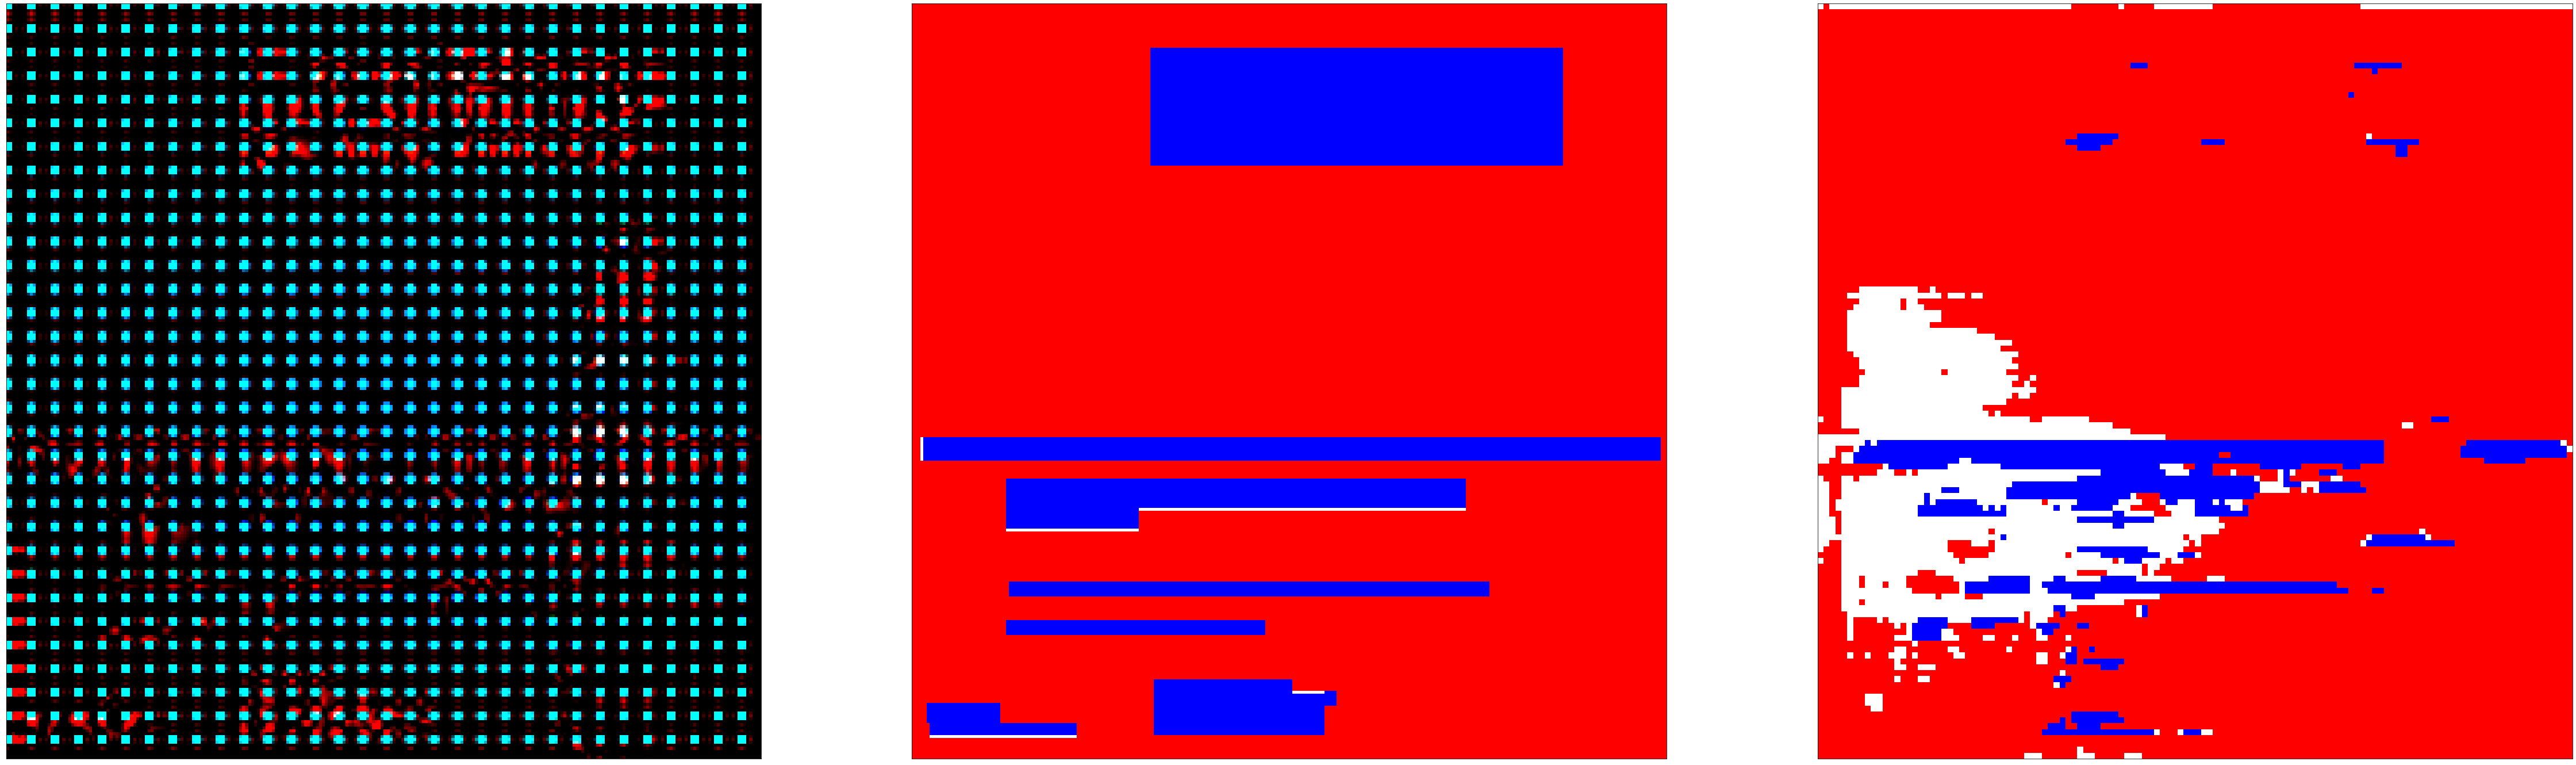

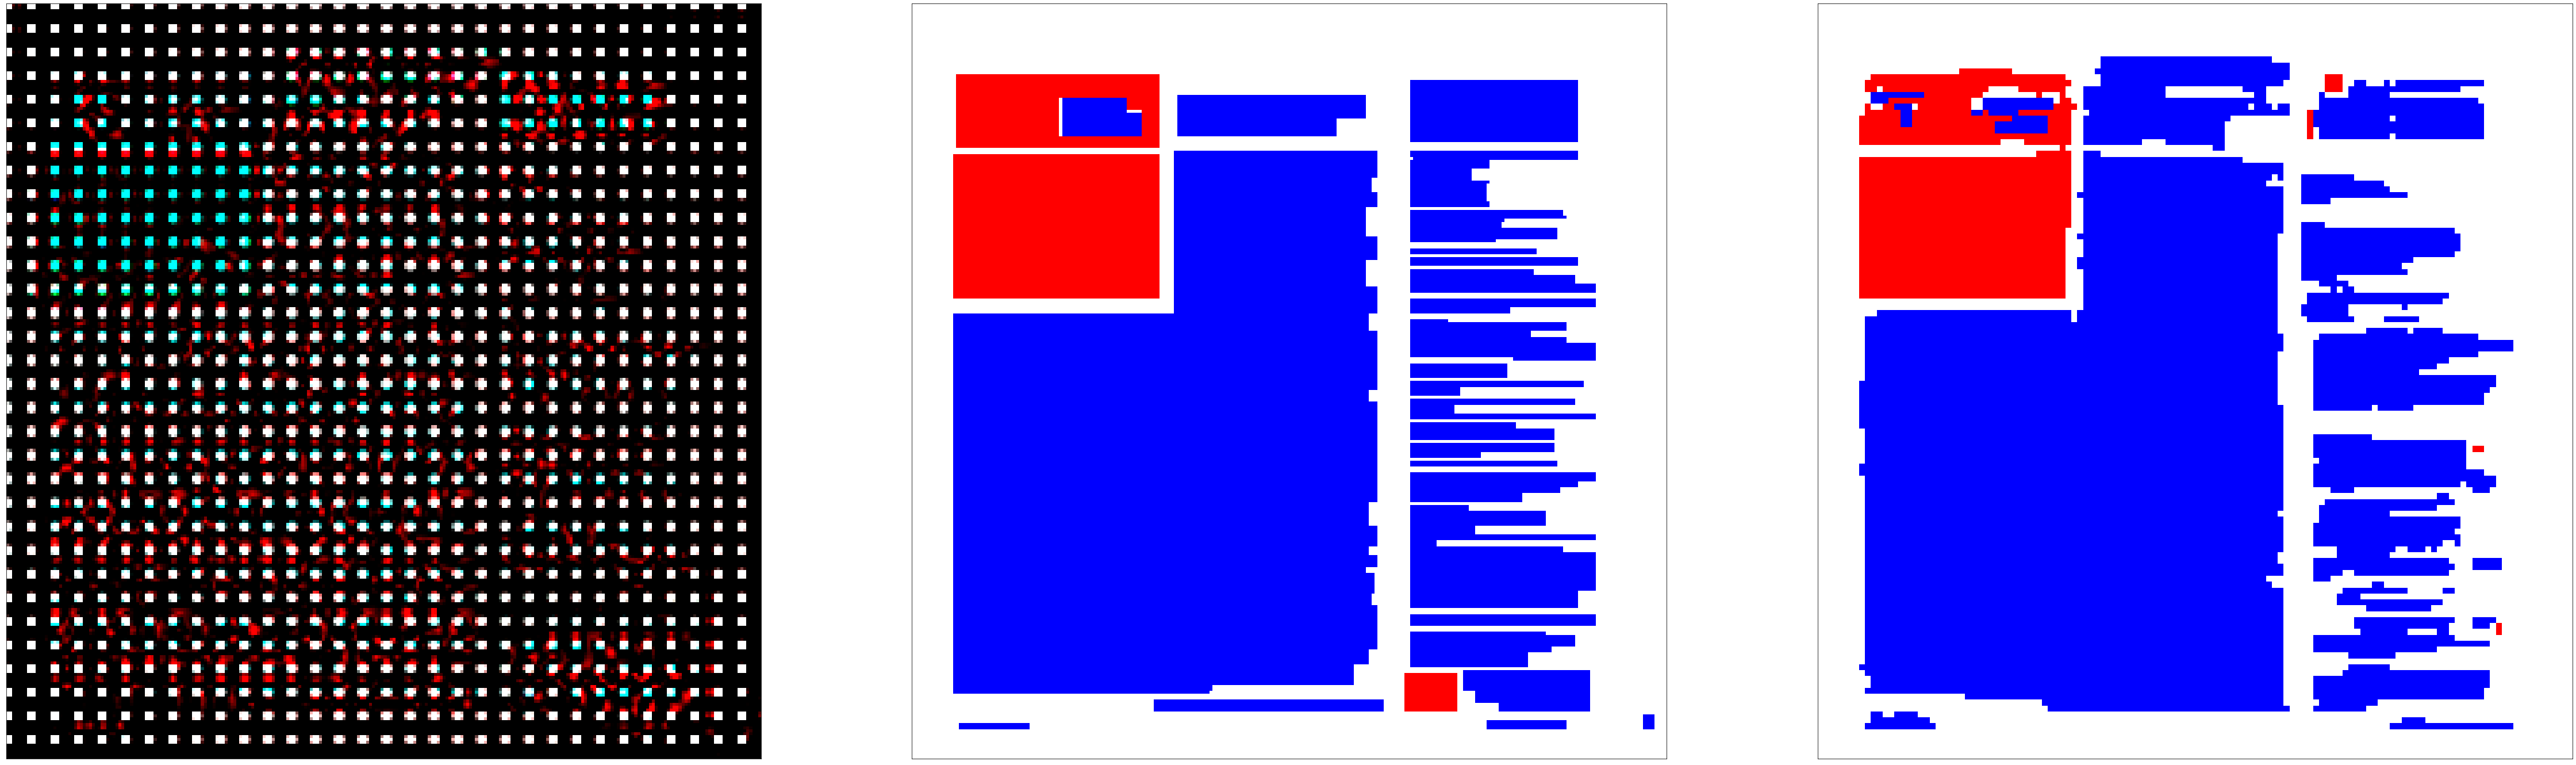

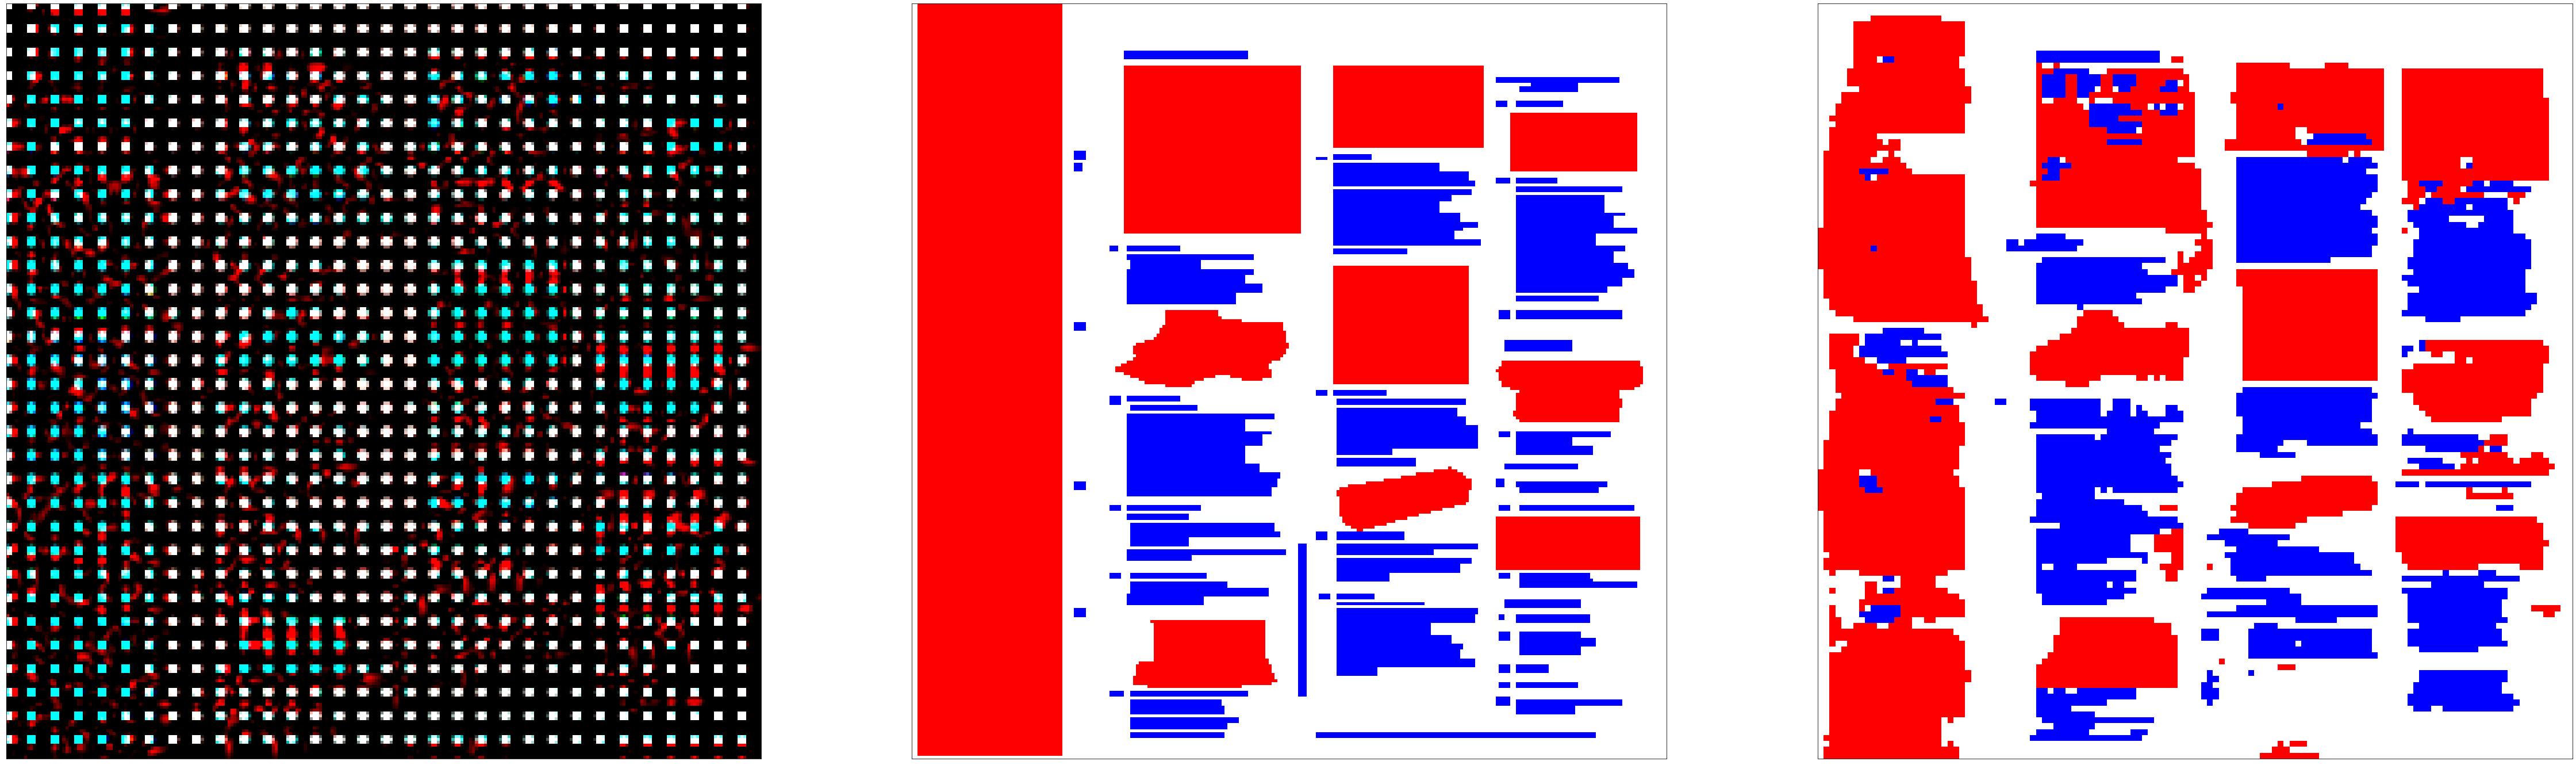

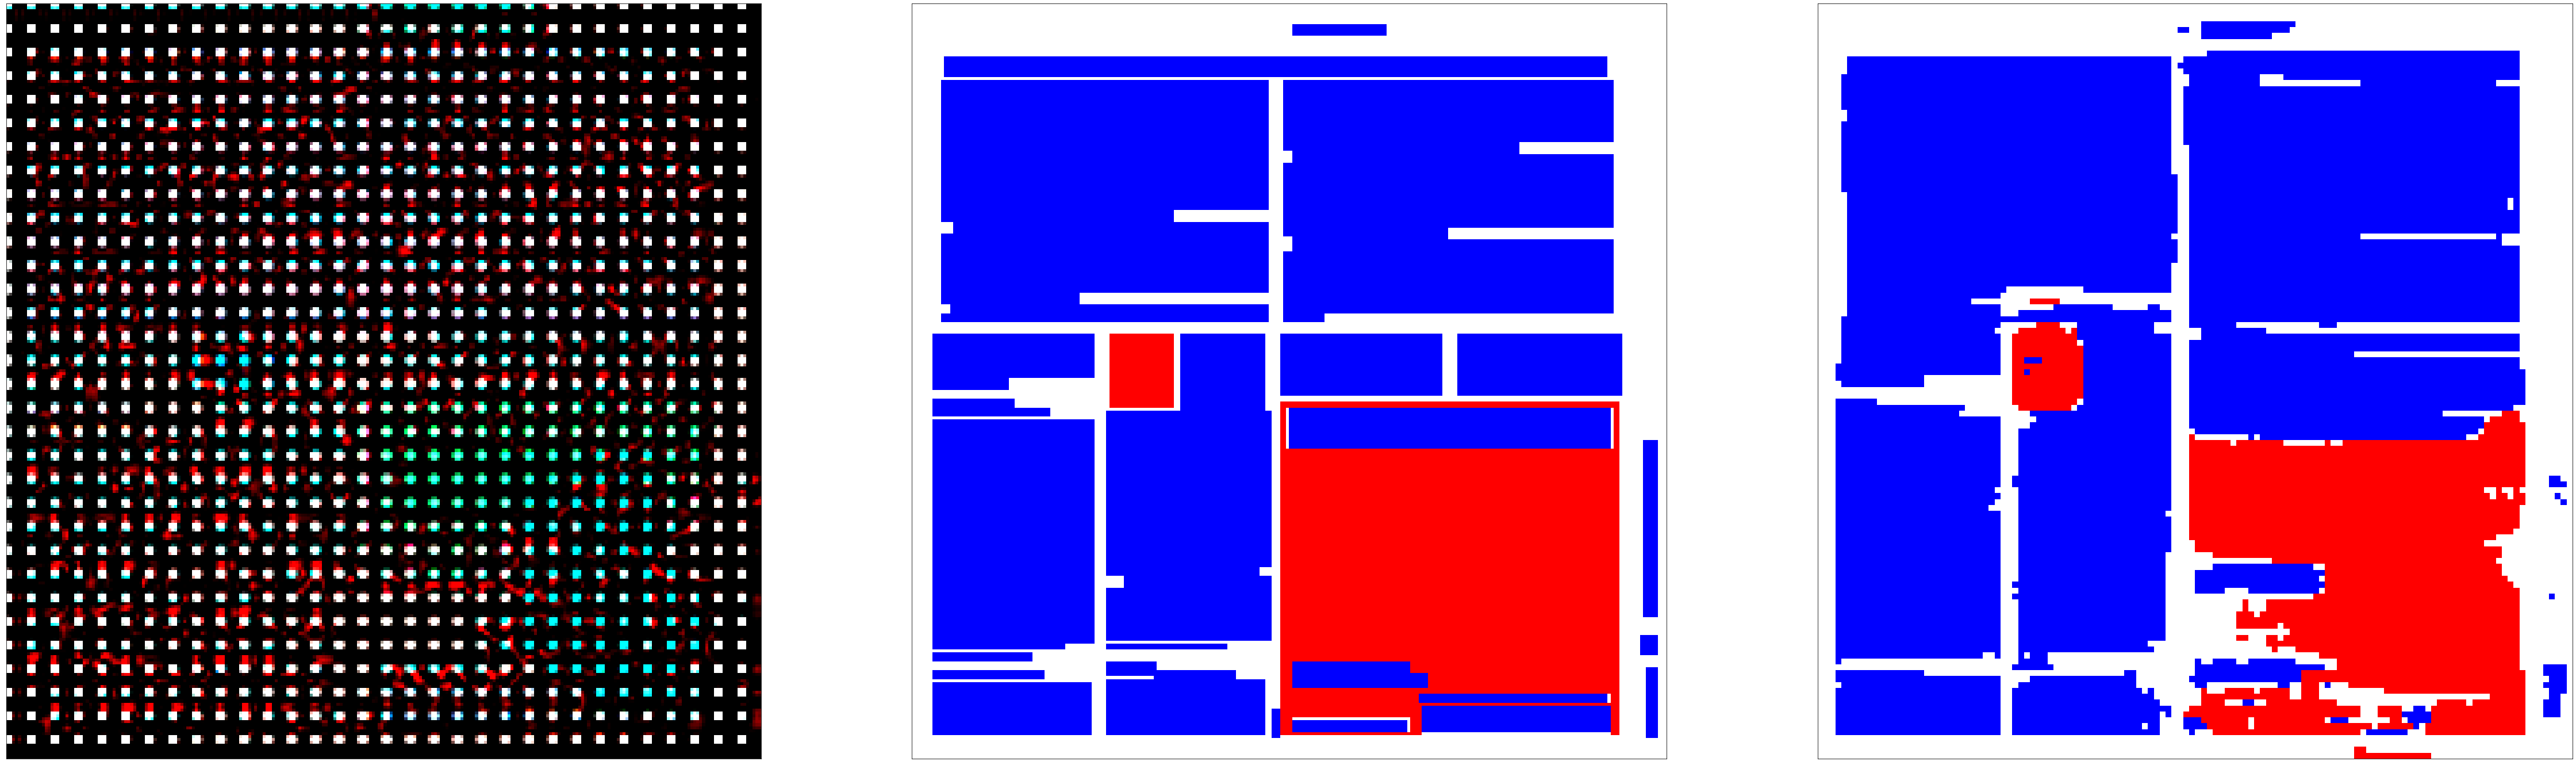

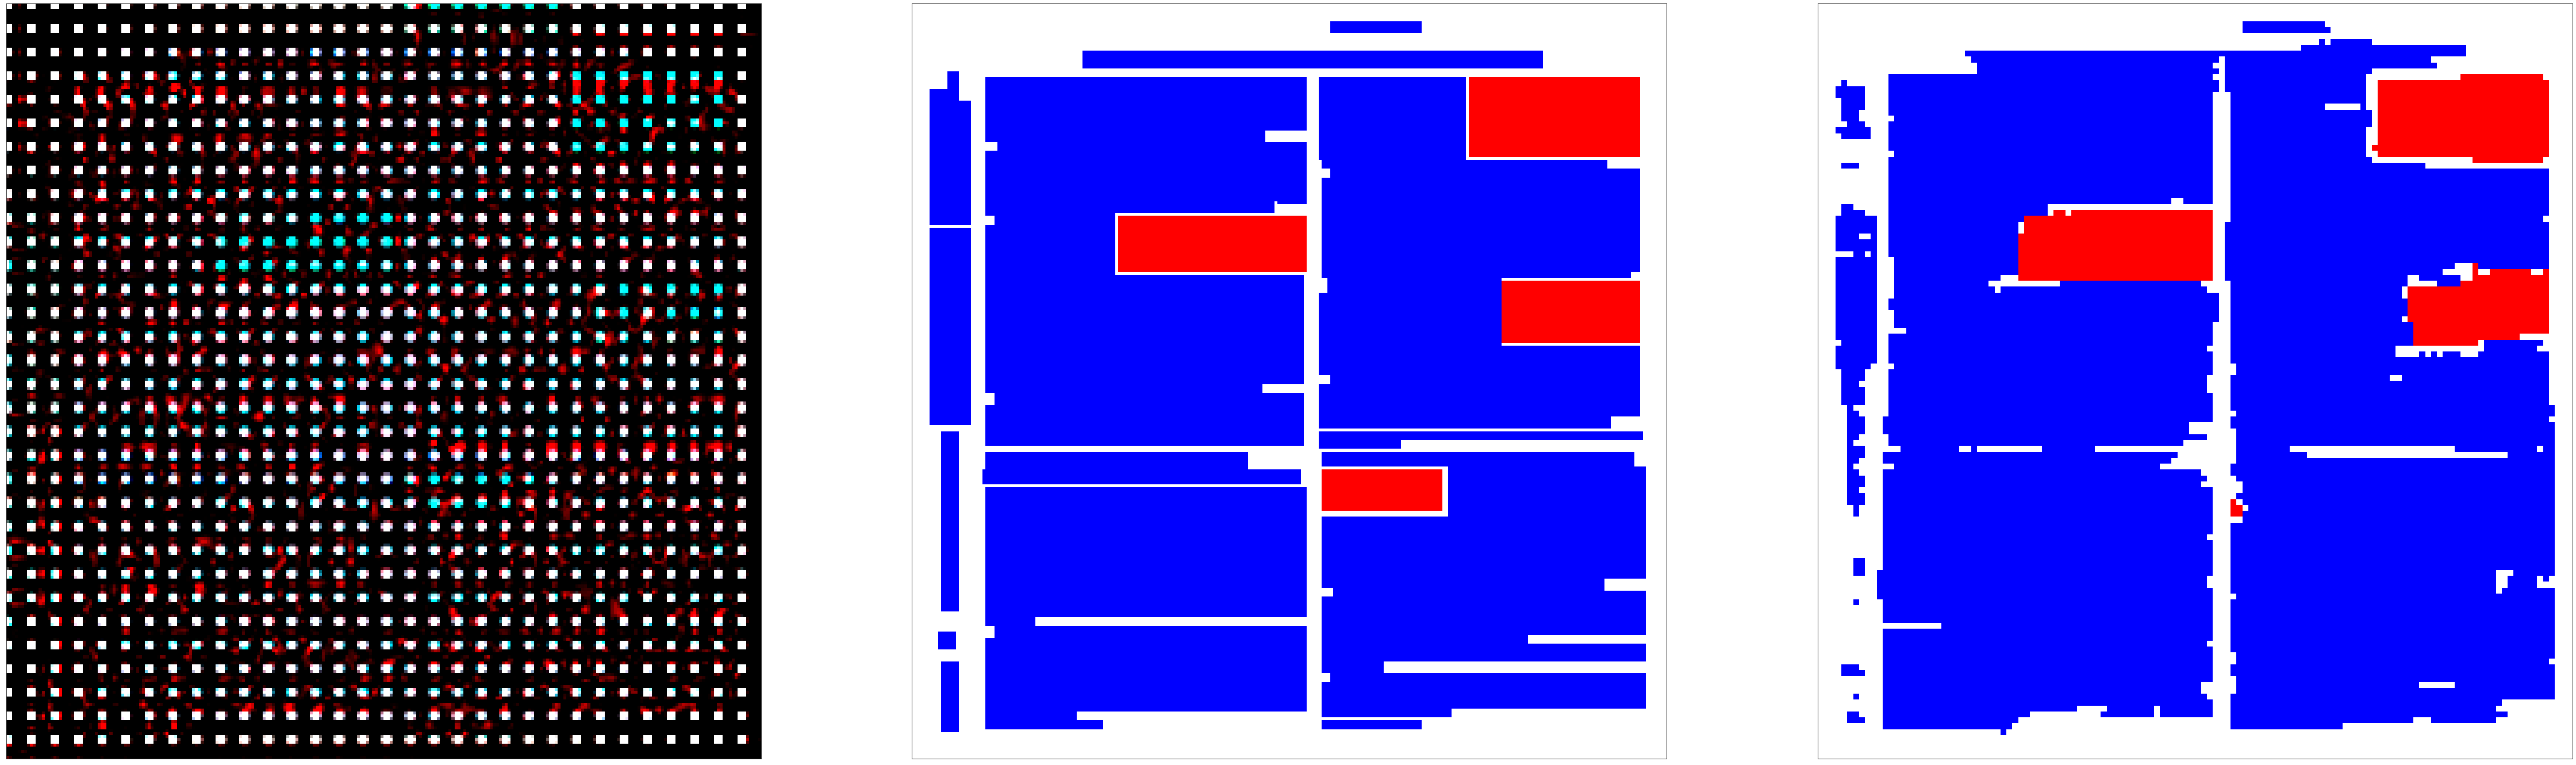

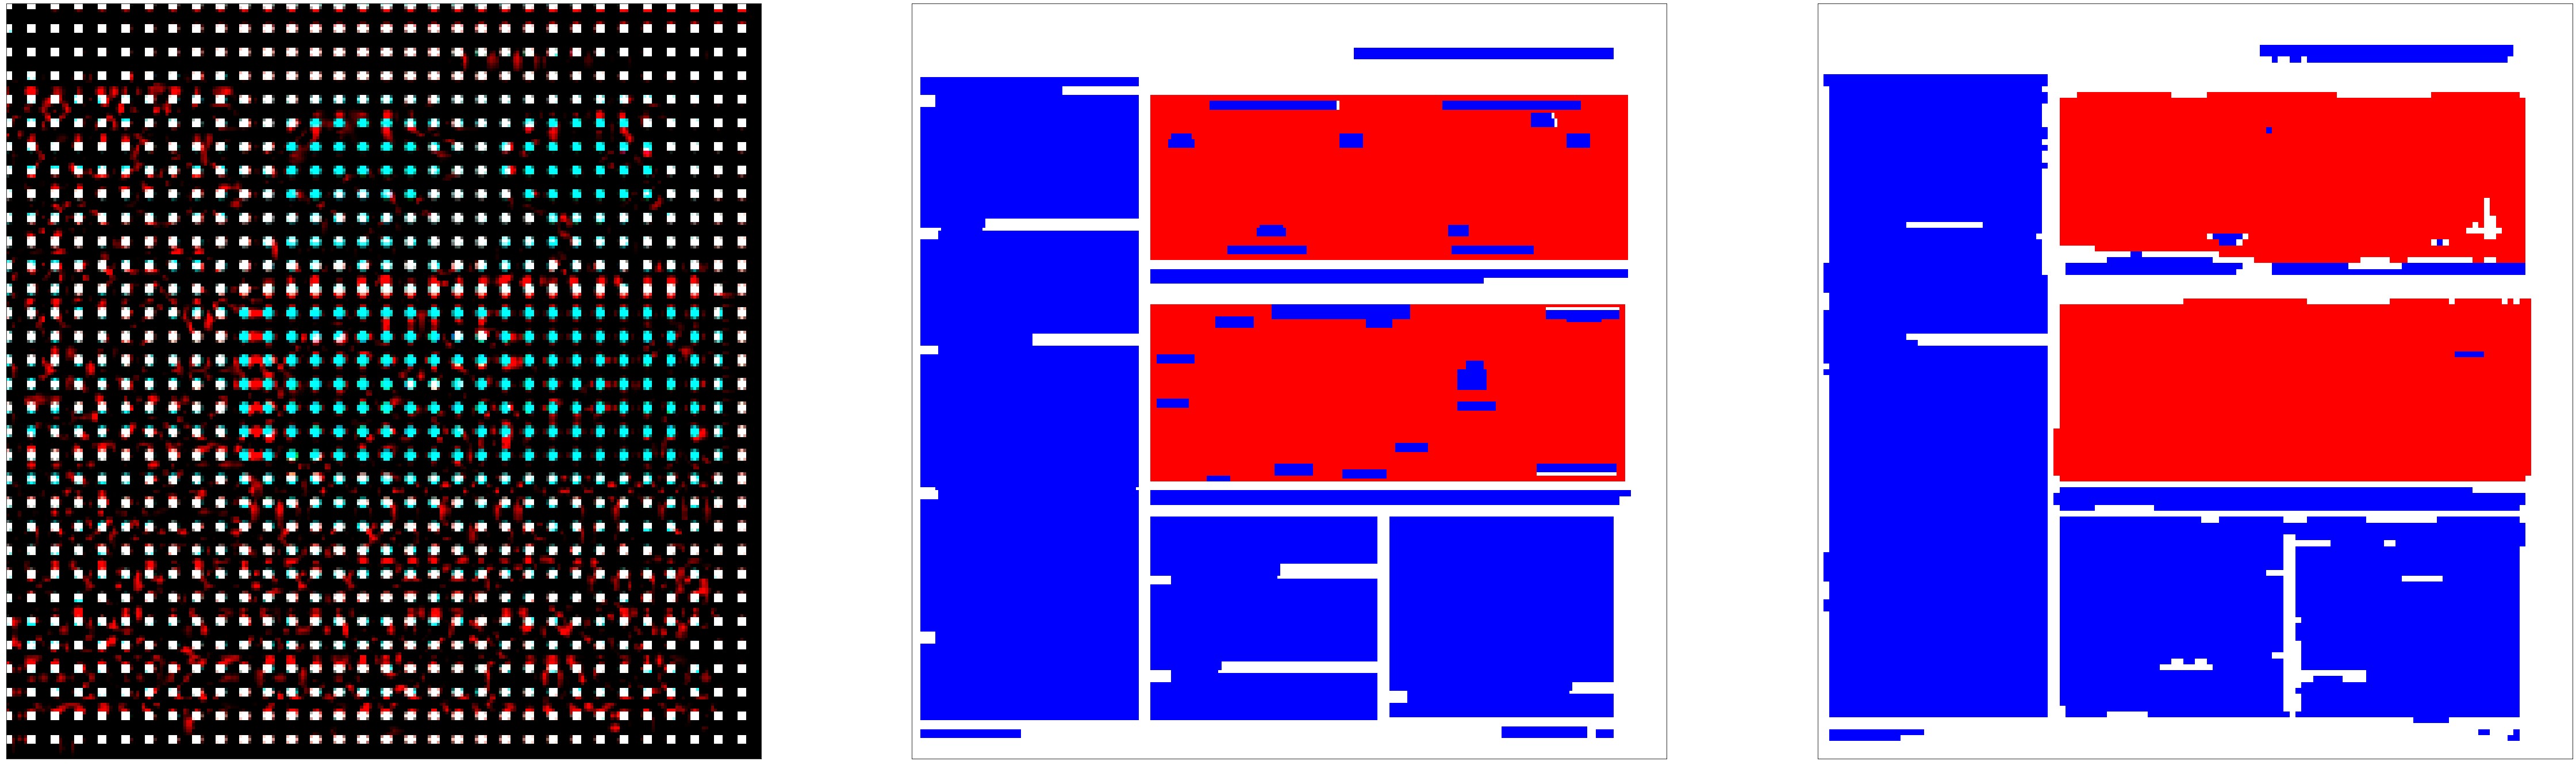

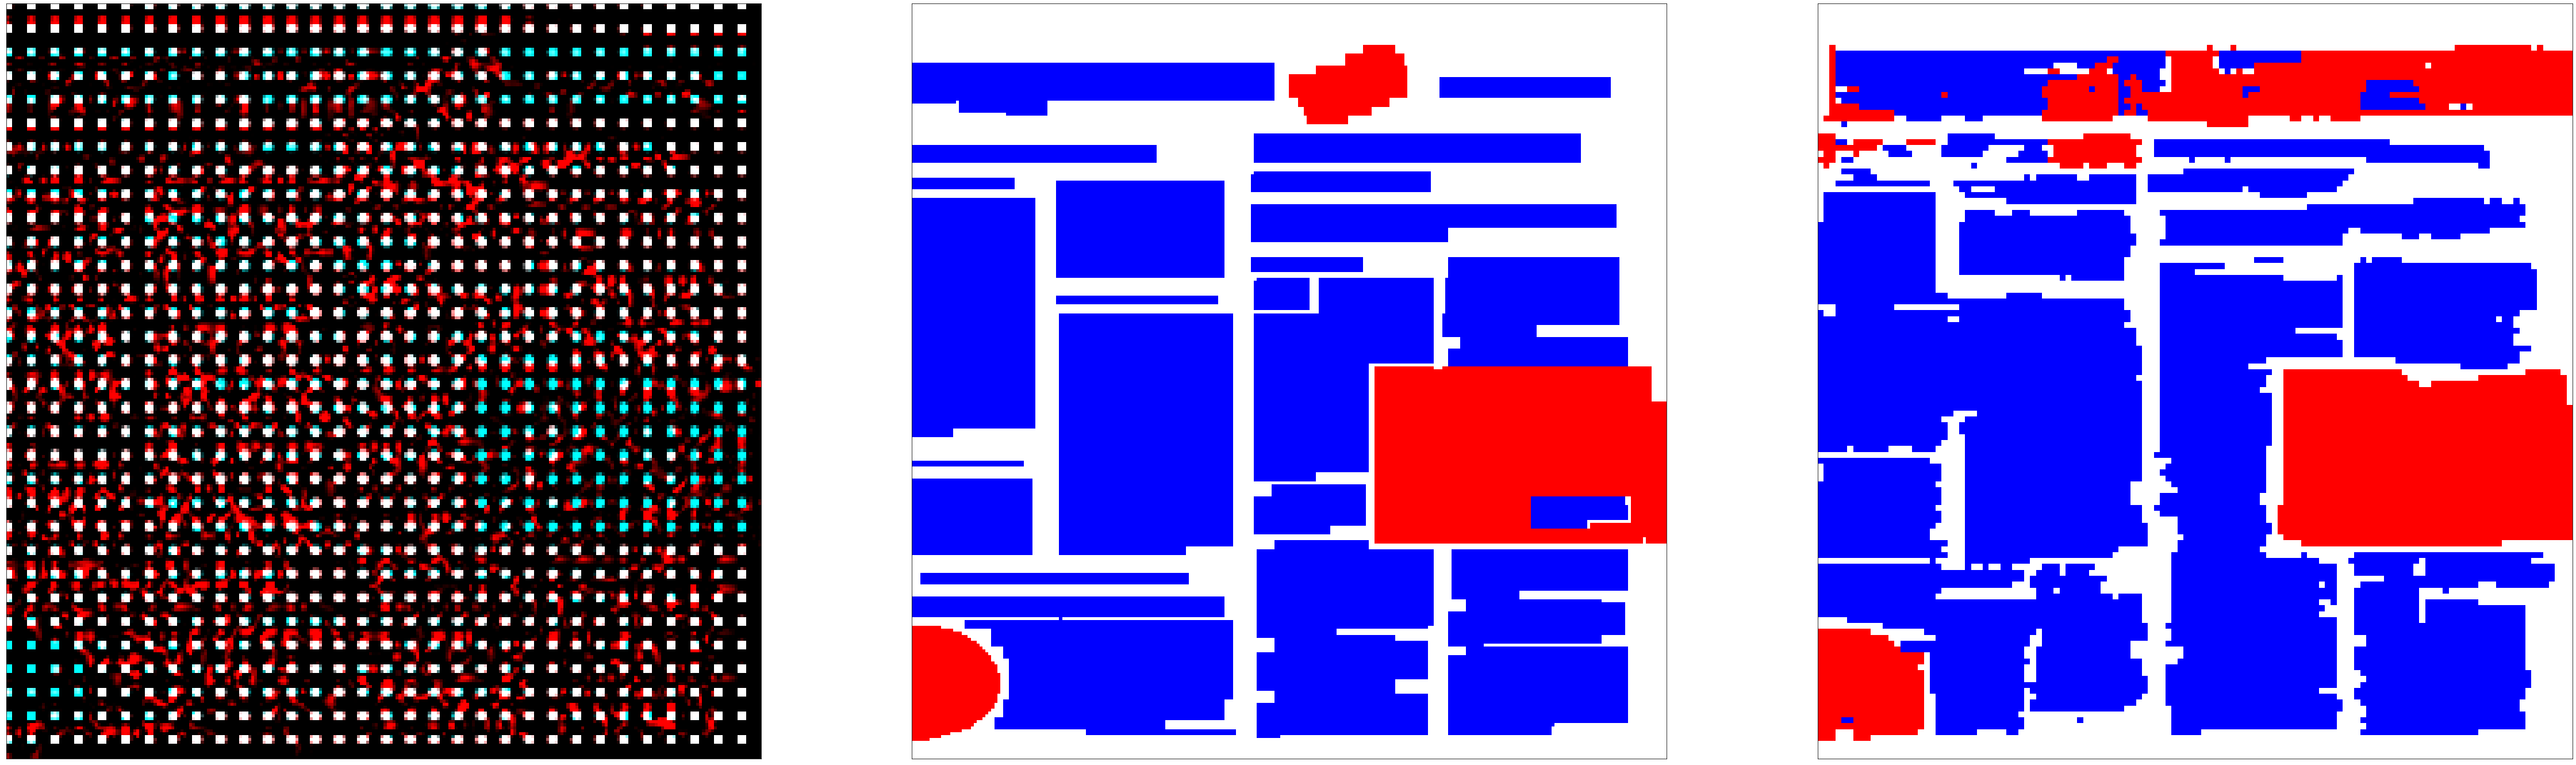

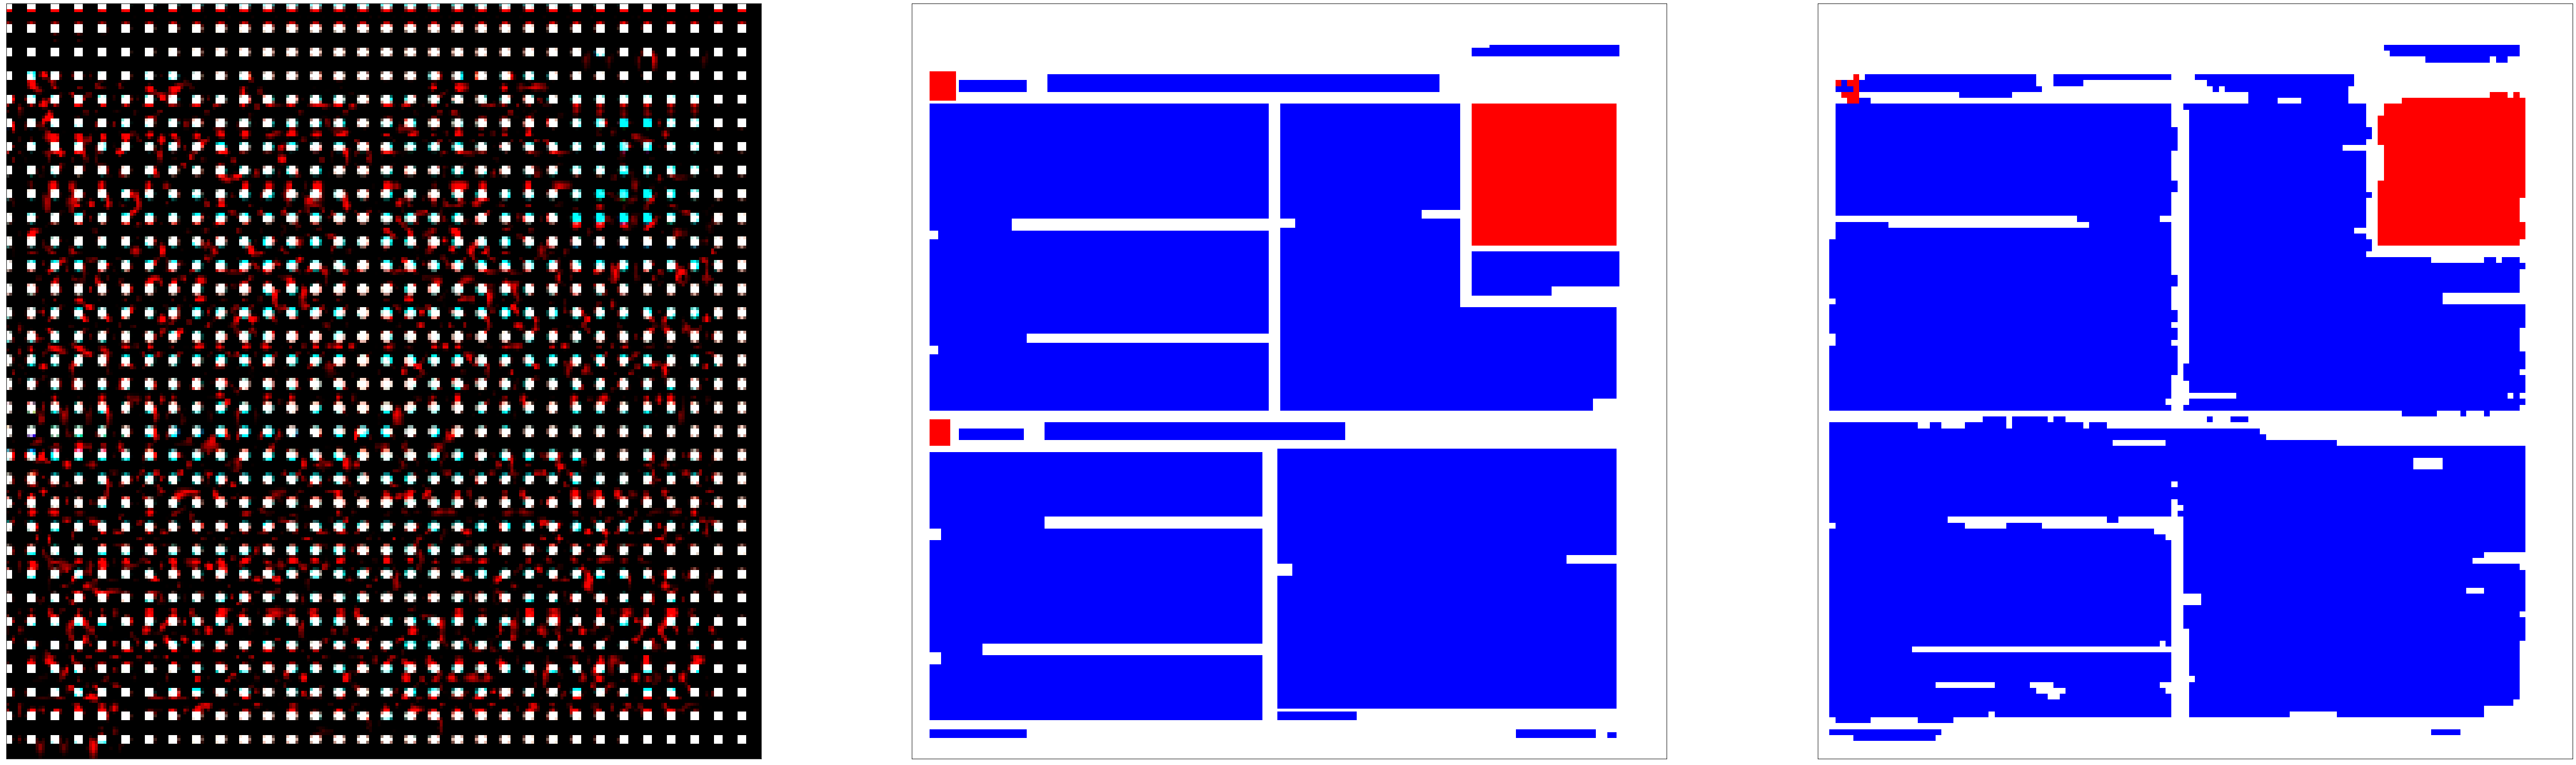

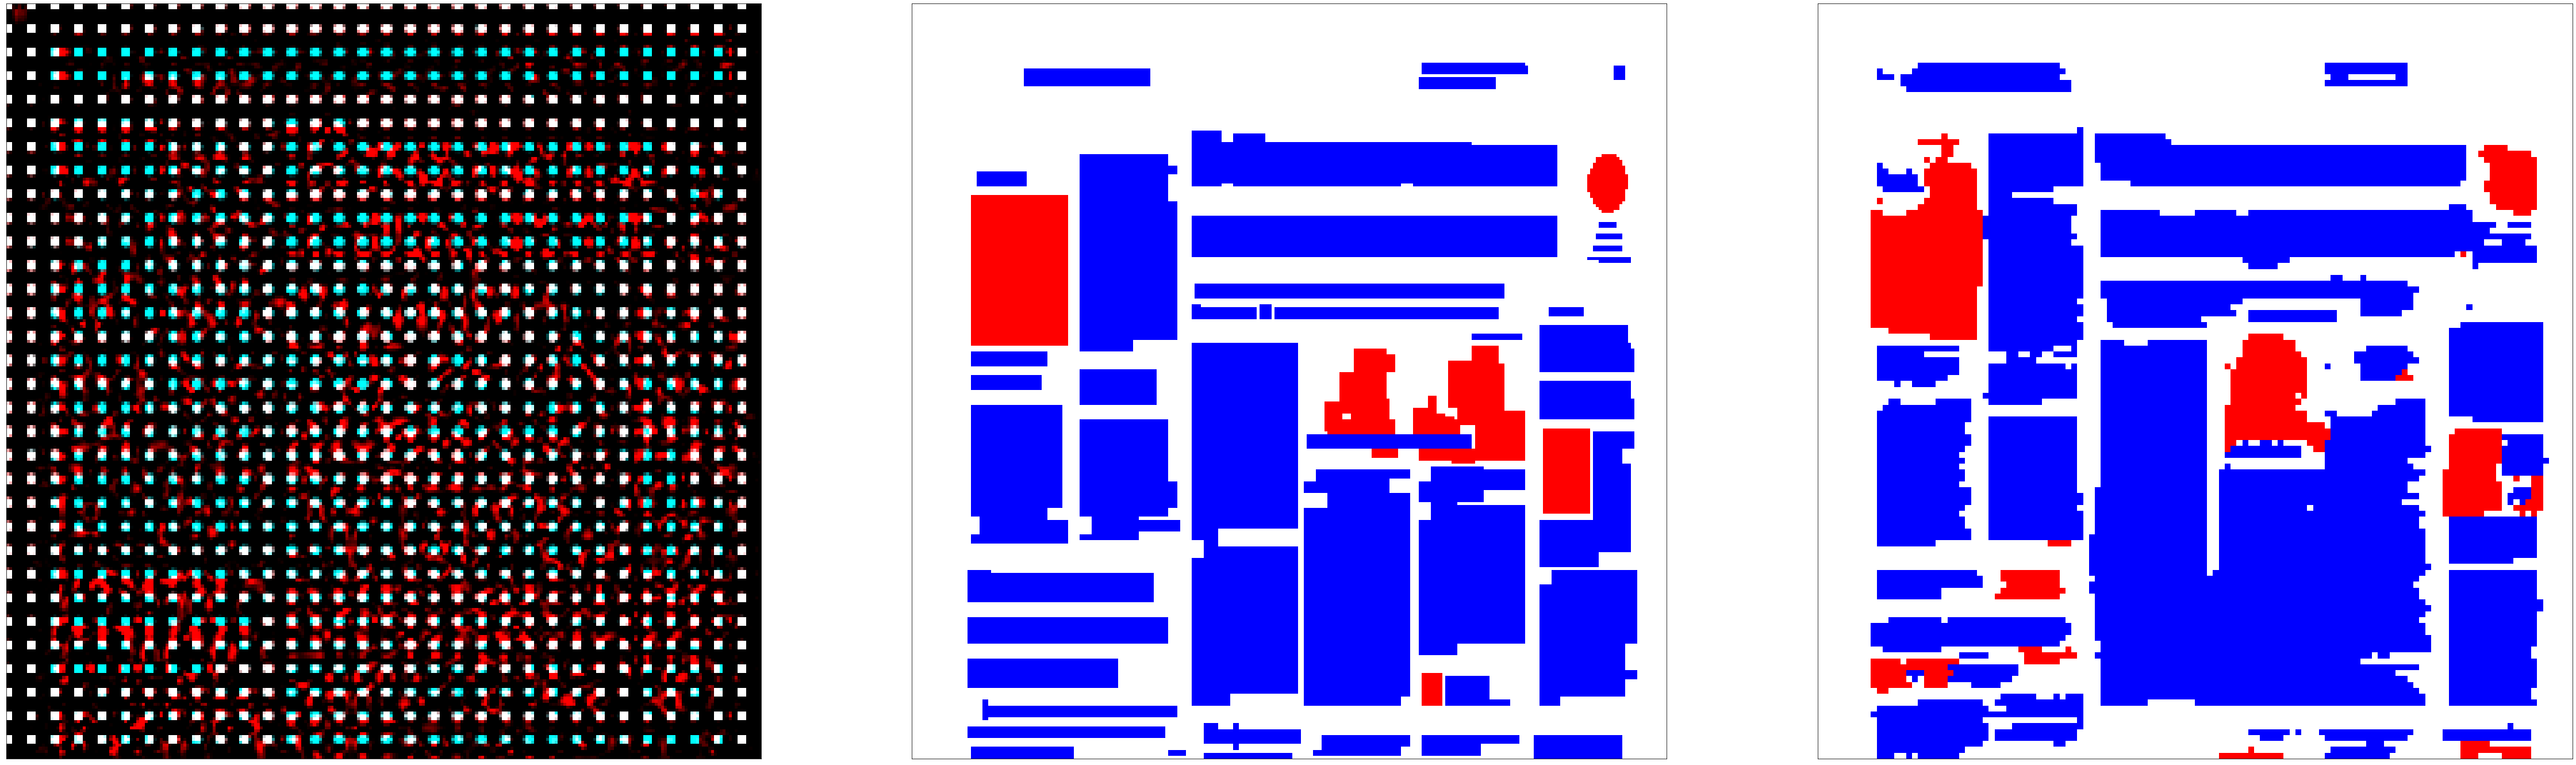

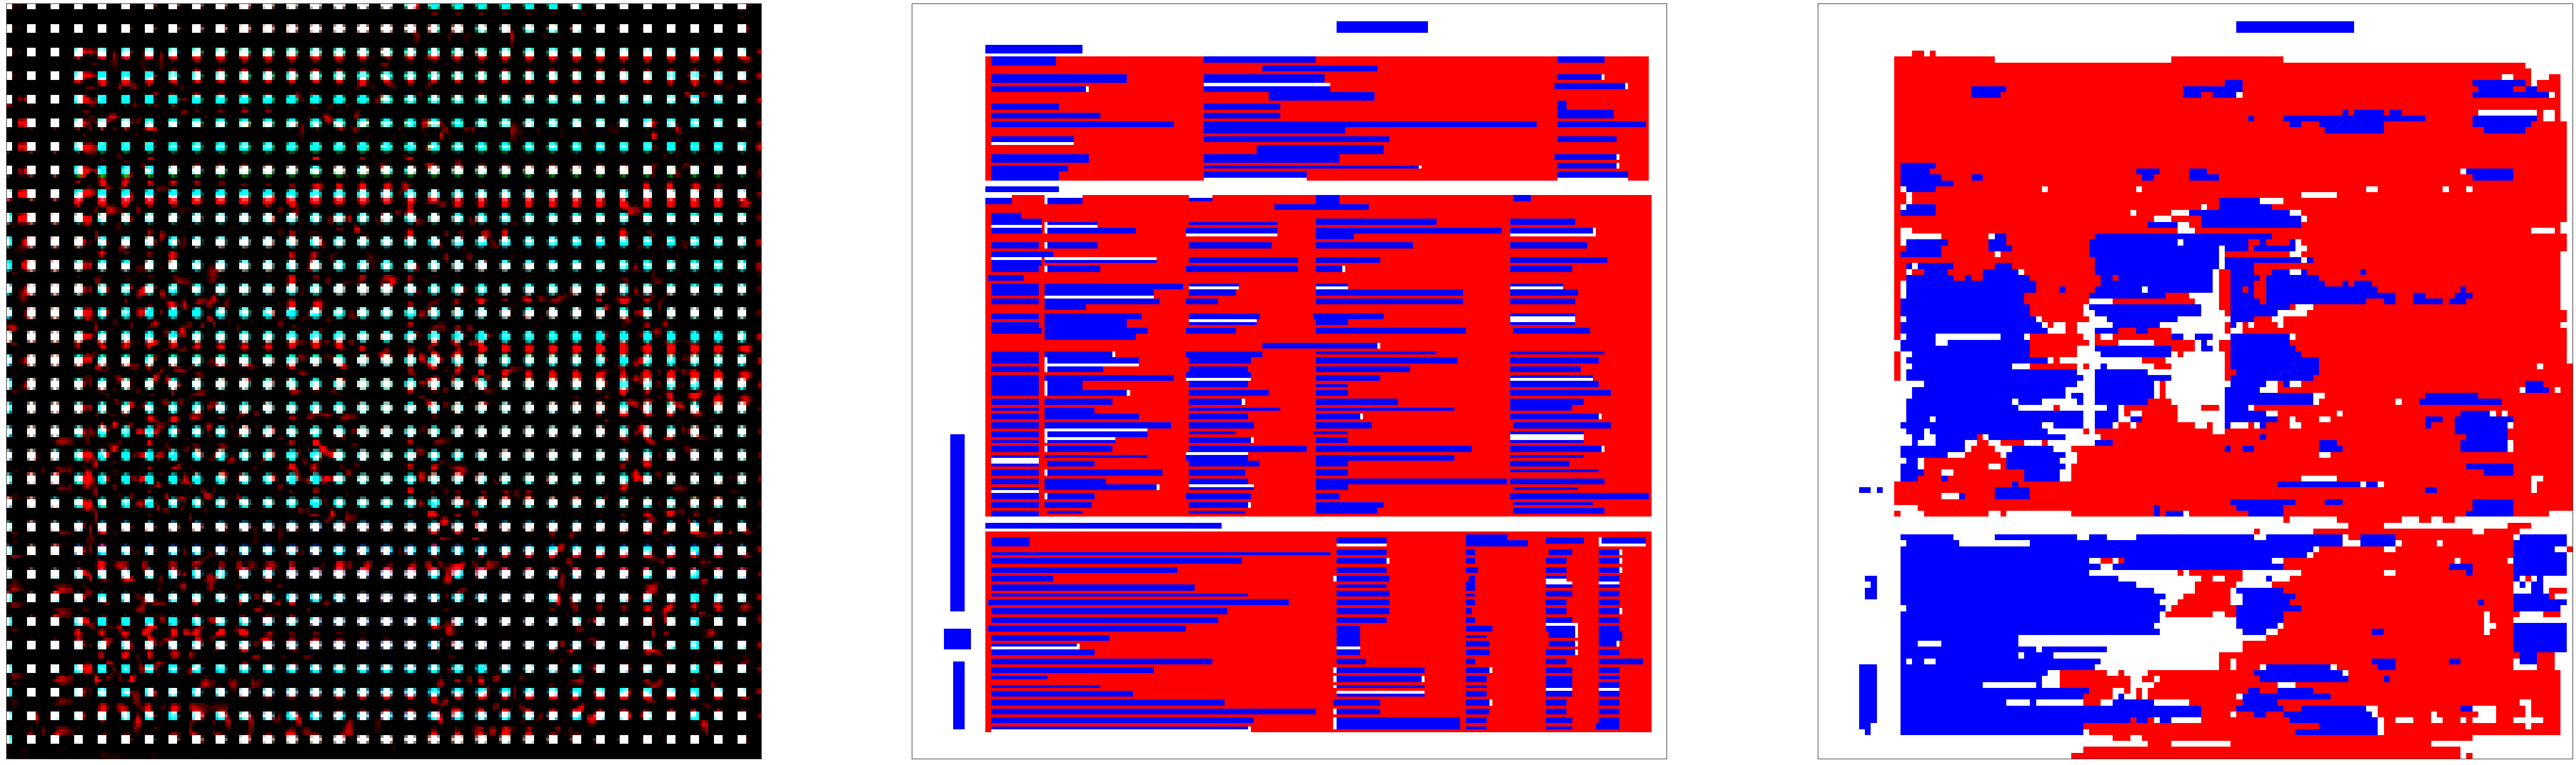

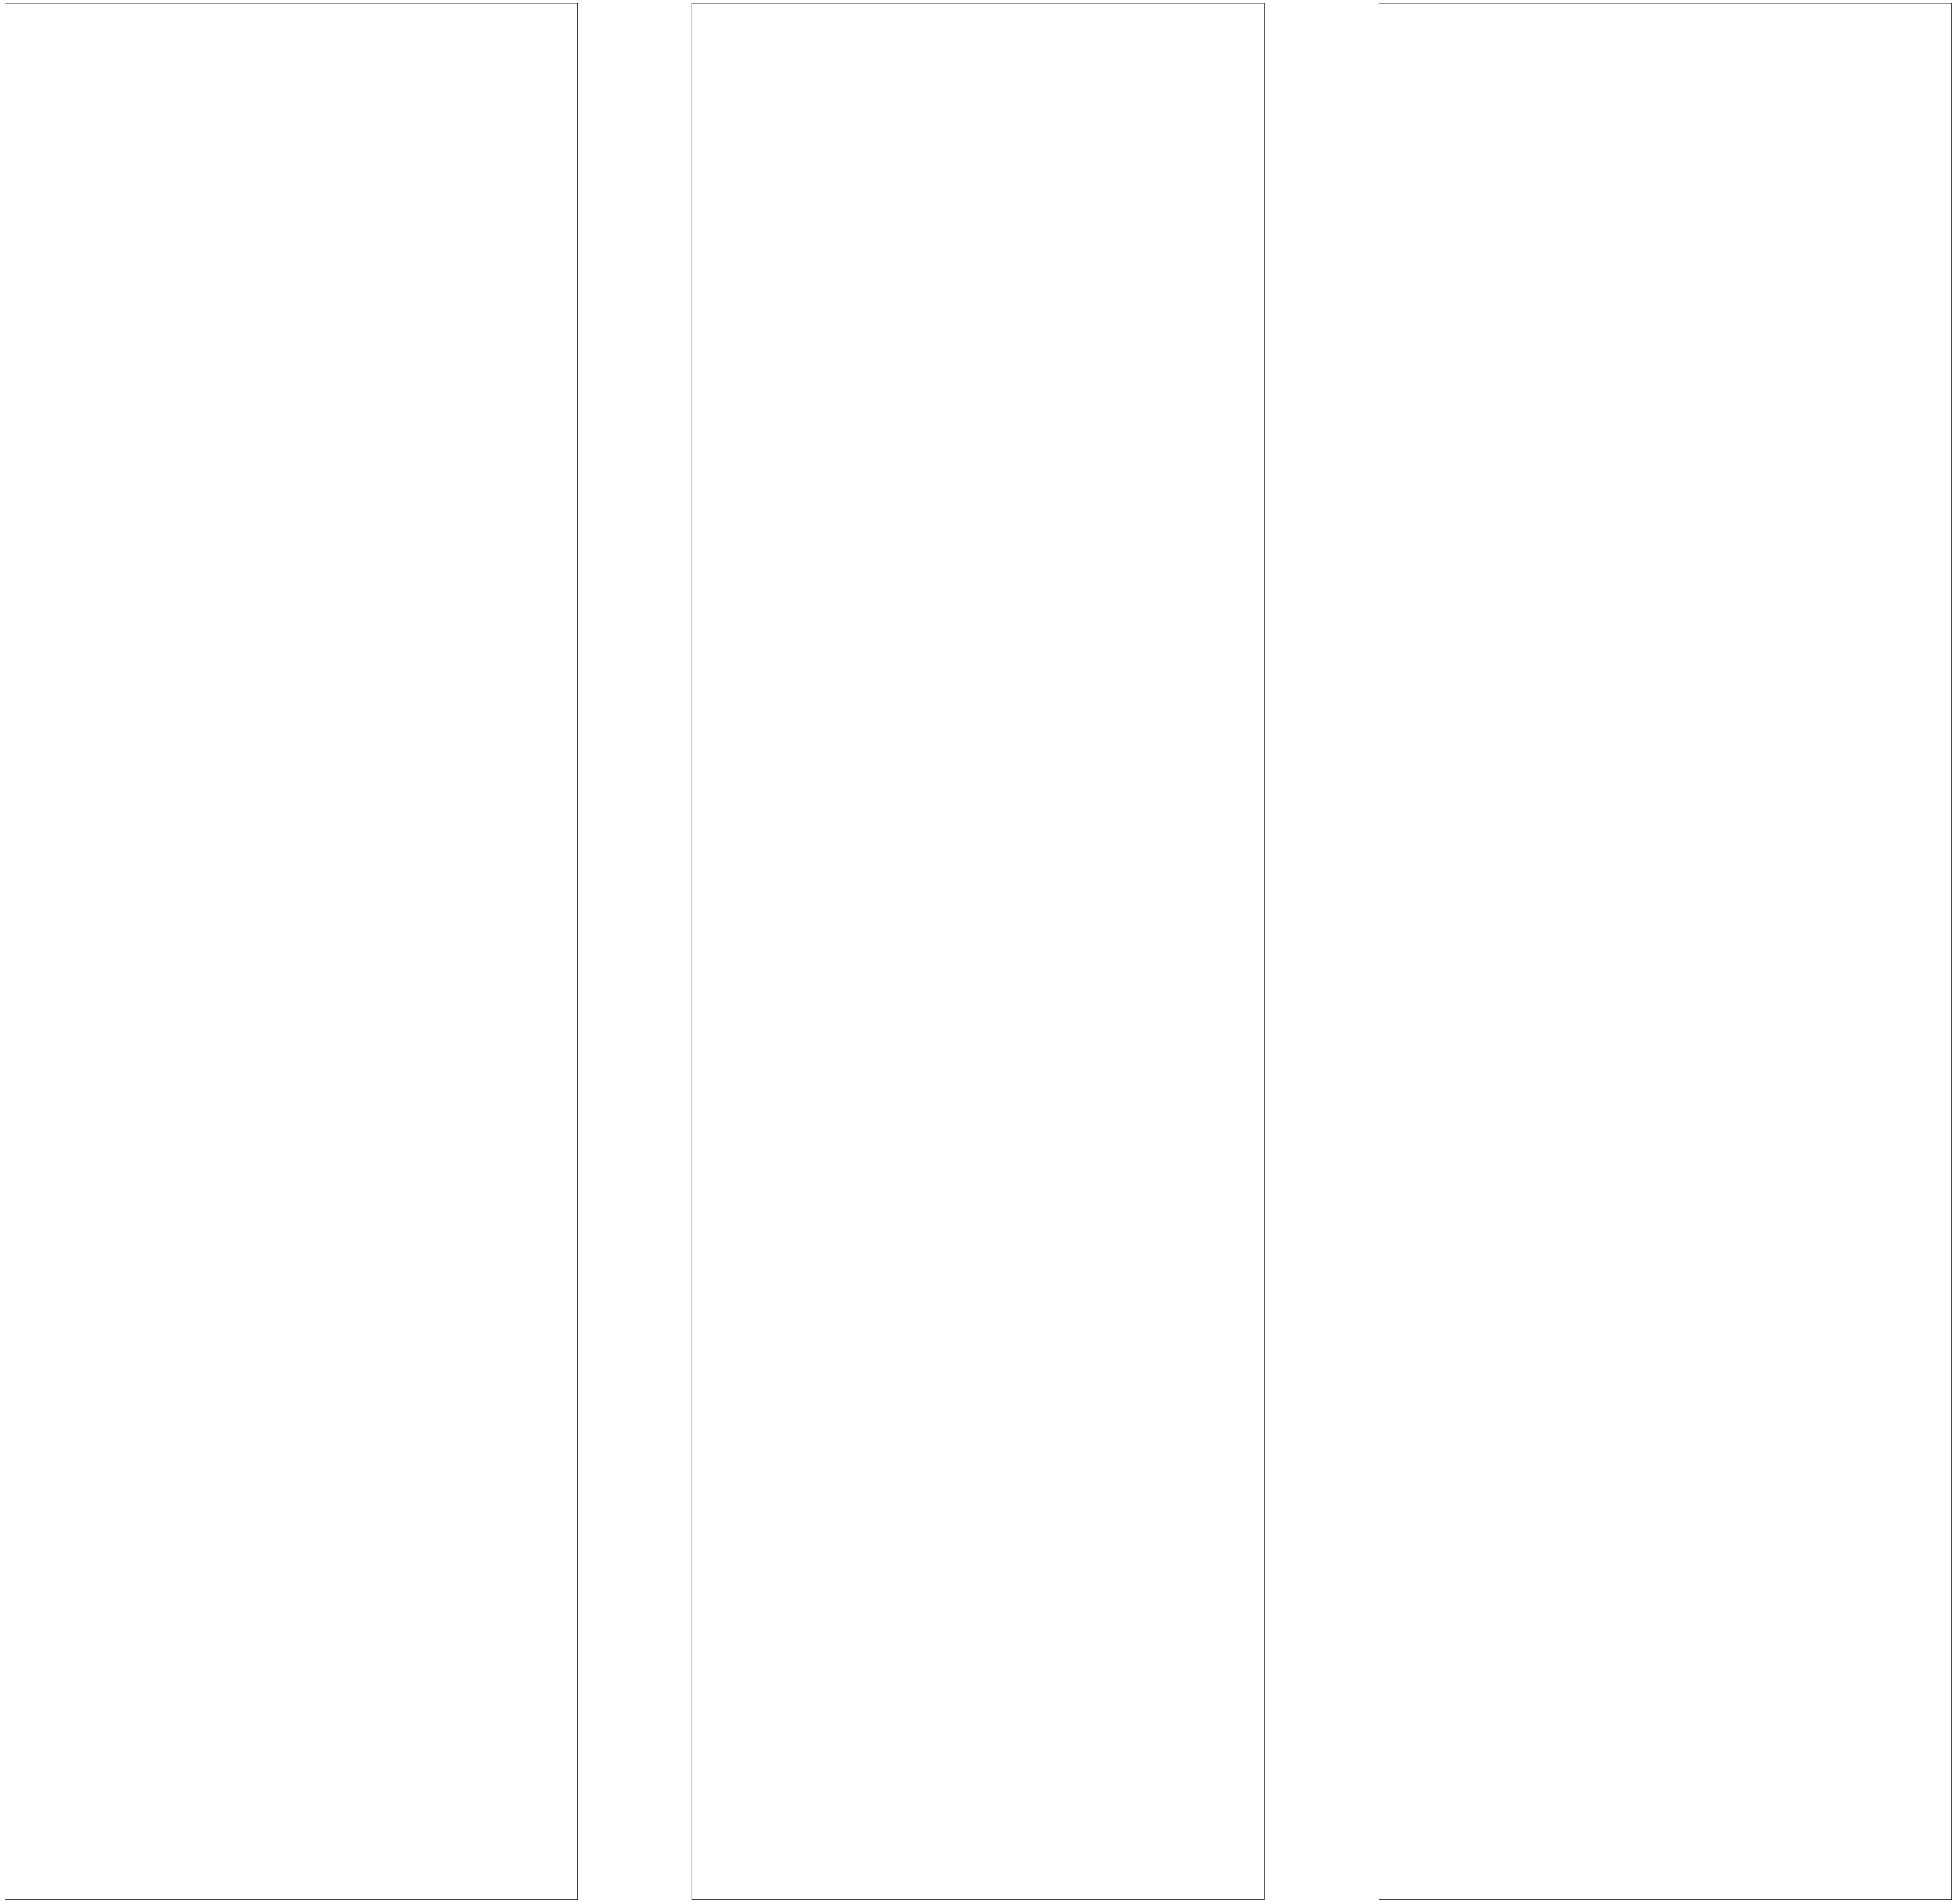

In [ ]:
y_hat = model_hrnet.predict(x_test)
for i in range(6,25):
  offset = 0
  im_rows = 1
  im_cols = 3
  fig, ax = plt.subplots(offset + im_rows, im_cols, figsize=(80,80))
  ax[0].set_xticks([])
  ax[1].set_xticks([])
  ax[2].set_xticks([])
  ax[0].set_yticks([])
  ax[1].set_yticks([])
  ax[2].set_yticks([])
  ax[0].imshow(x_test[i,:,:,:])
  ax[1].imshow(output_debinarisation(y_test[i,:,:,:]))
  ax[2].imshow(output_debinarisation(y_hat[i,:,:,:]))

In [ ]:
y_hat = model_hrnet.predict(x_test)

In [ ]:
average_precisions = [average_precision_score(y_test_i.reshape(-1),y_hat_i.reshape(-1)) for (y_test_i,y_hat_i) in zip(y_test,y_hat)]
print(np.mean(average_precisions))

0.8147864524342616


###**FCN**
####Plotting of loss, accuracy, mean dice, and mean iou
####Print sample outputs
####Mean average precision (mAP)



In [ ]:
plt.plot(hist_fcn.history['loss'], color='r')
plt.plot(hist_fcn.history['val_loss'], color='b')
plt.legend(('loss','val_loss'))
plt.show()

In [ ]:
plt.plot(hist_fcn.history['accuracy'], color='g')
plt.plot(hist_fcn.history['val_accuracy'], color='y')
plt.legend(('acc','val_acc'))
plt.show()

In [ ]:
plt.plot(hist_fcn.history['mean_dice'], color='g')
plt.plot(hist_fcn.history['val_mean_dice'], color='y')
plt.legend(('dice','val_dice'))
plt.show()

In [ ]:
plt.plot(hist_fcn.history['mean_iou'], color='g')
plt.plot(hist_fcn.history['val_mean_iou'], color='y')
plt.legend(('iou','val_iou'))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

IndexError: ignored

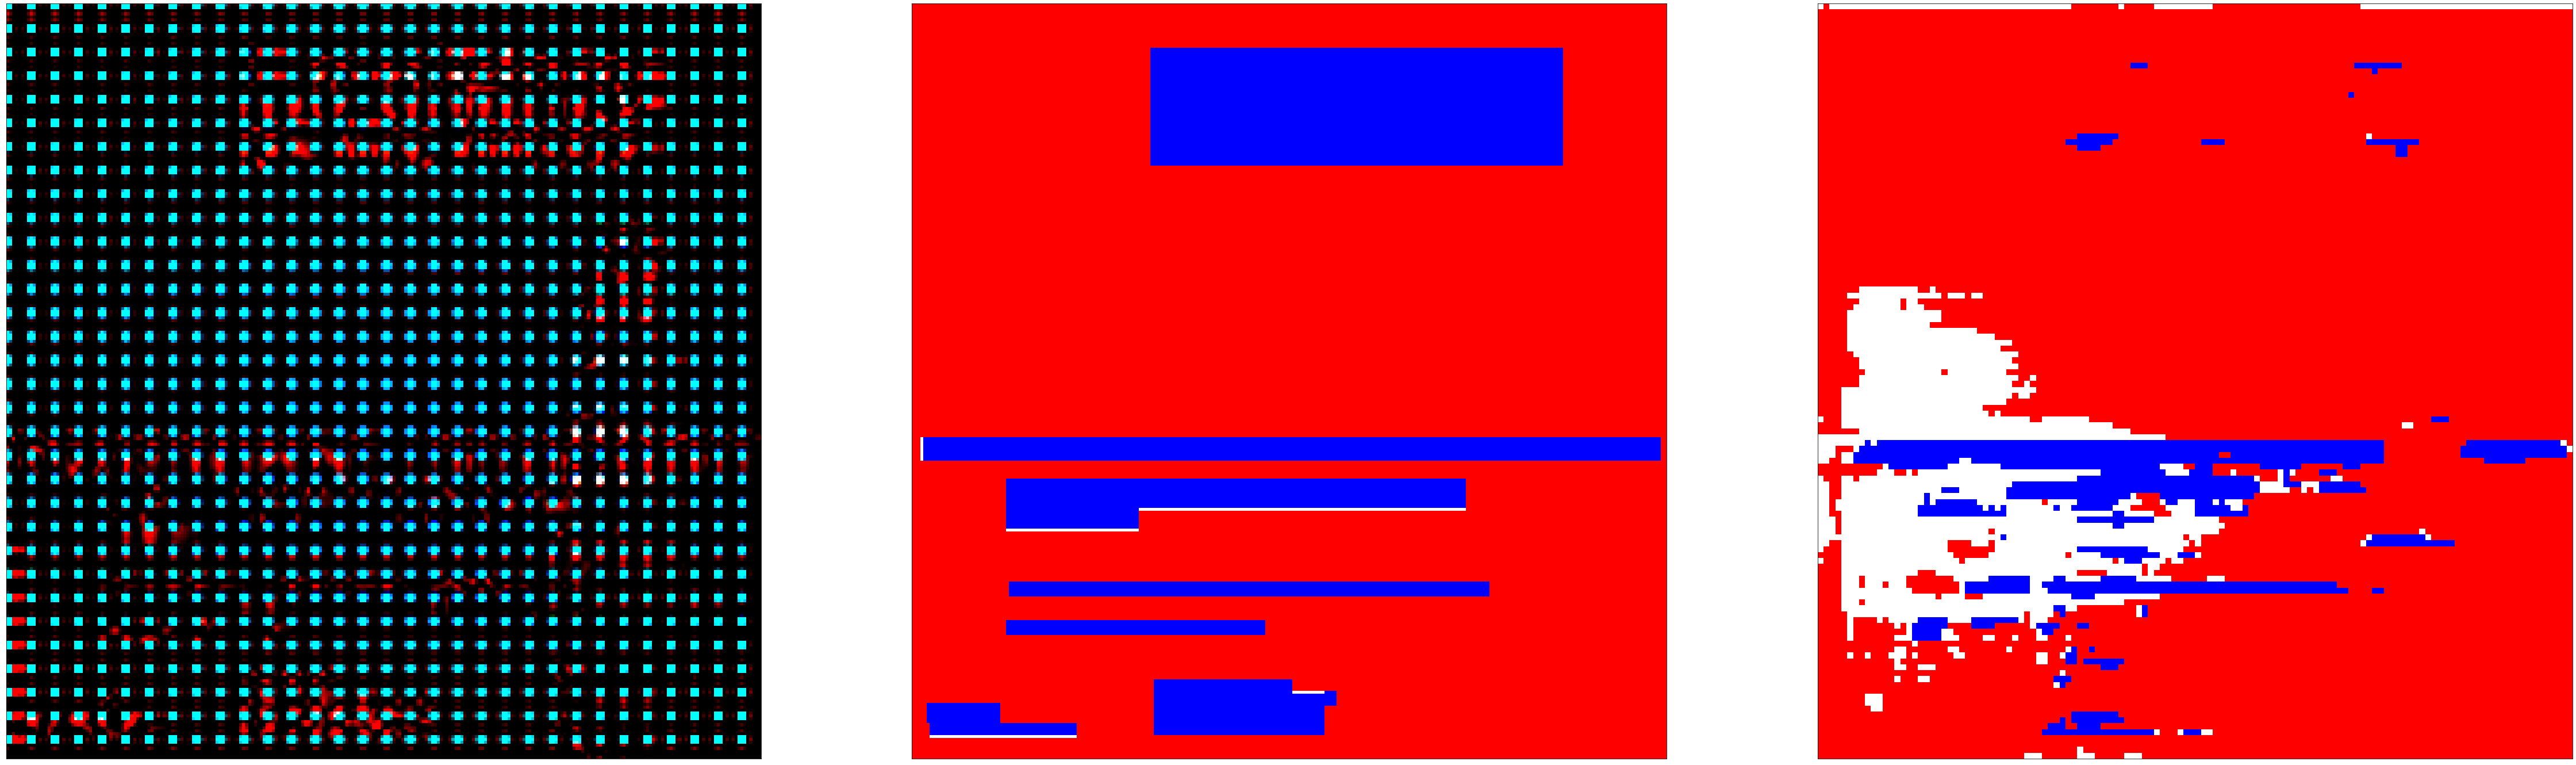

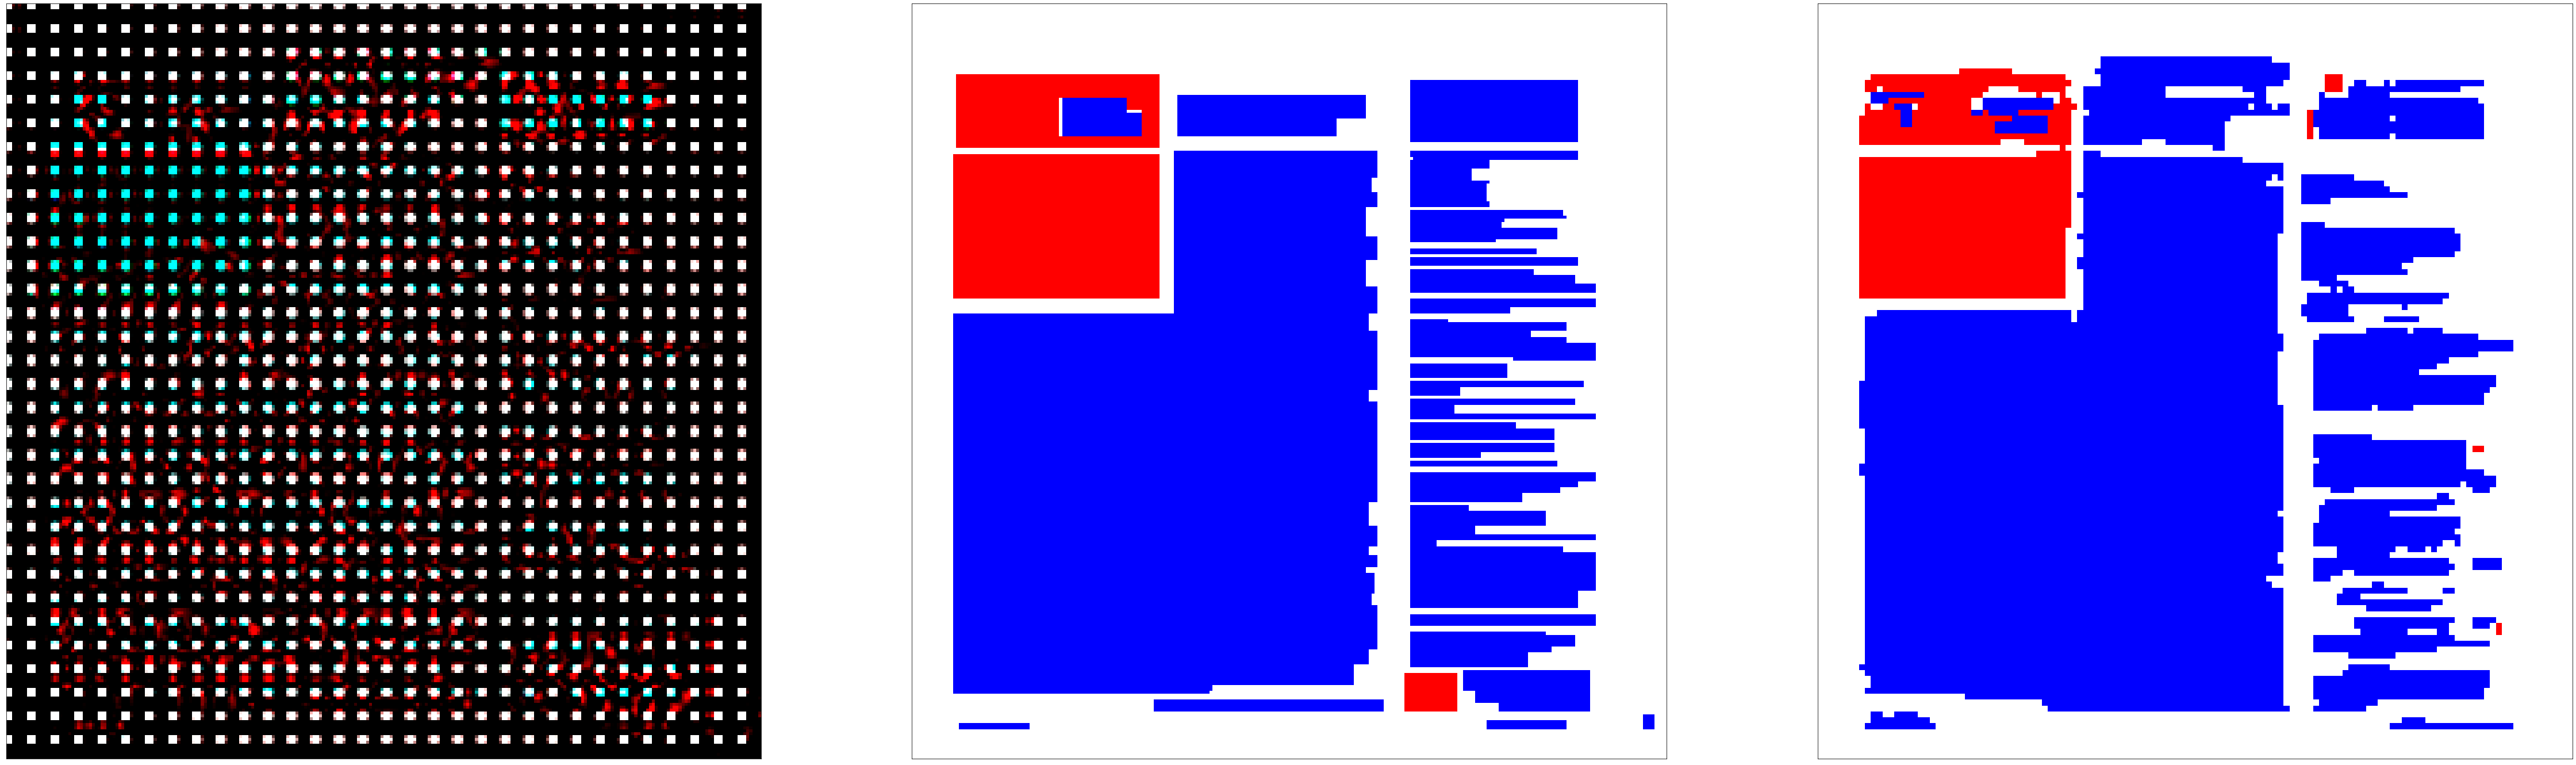

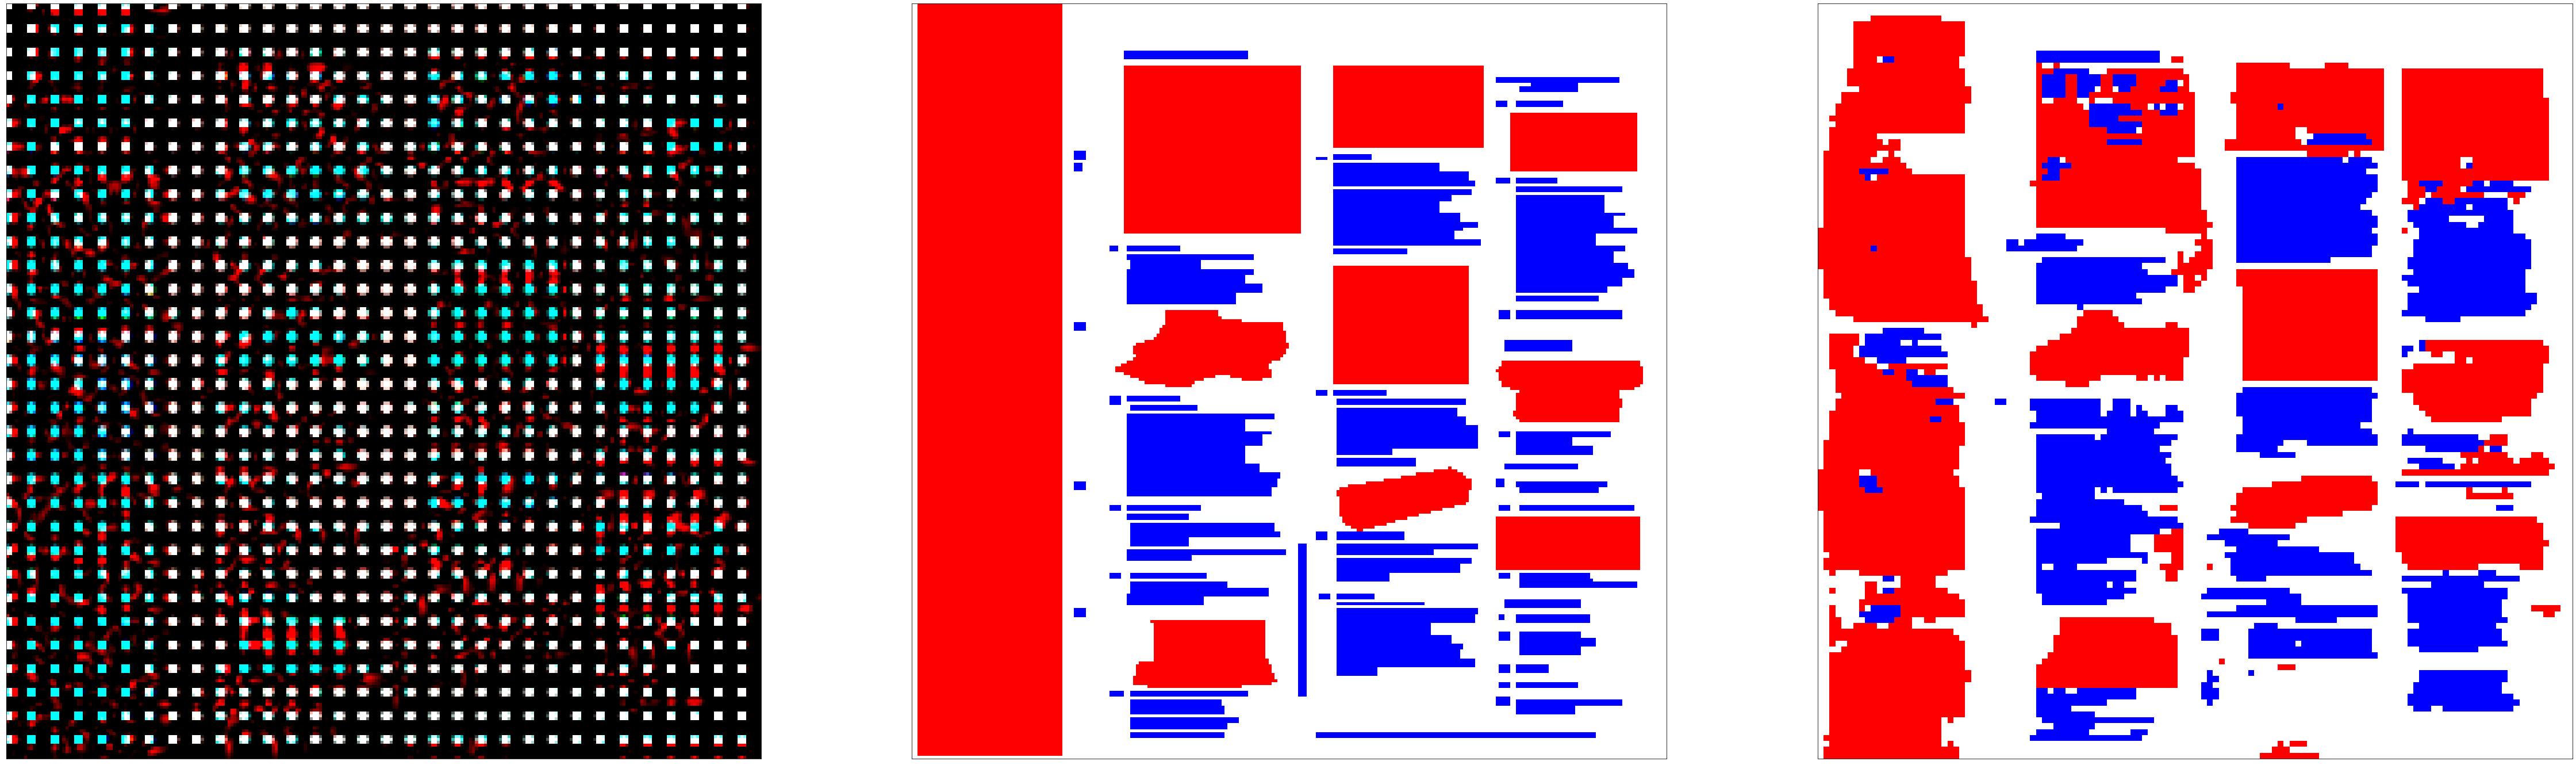

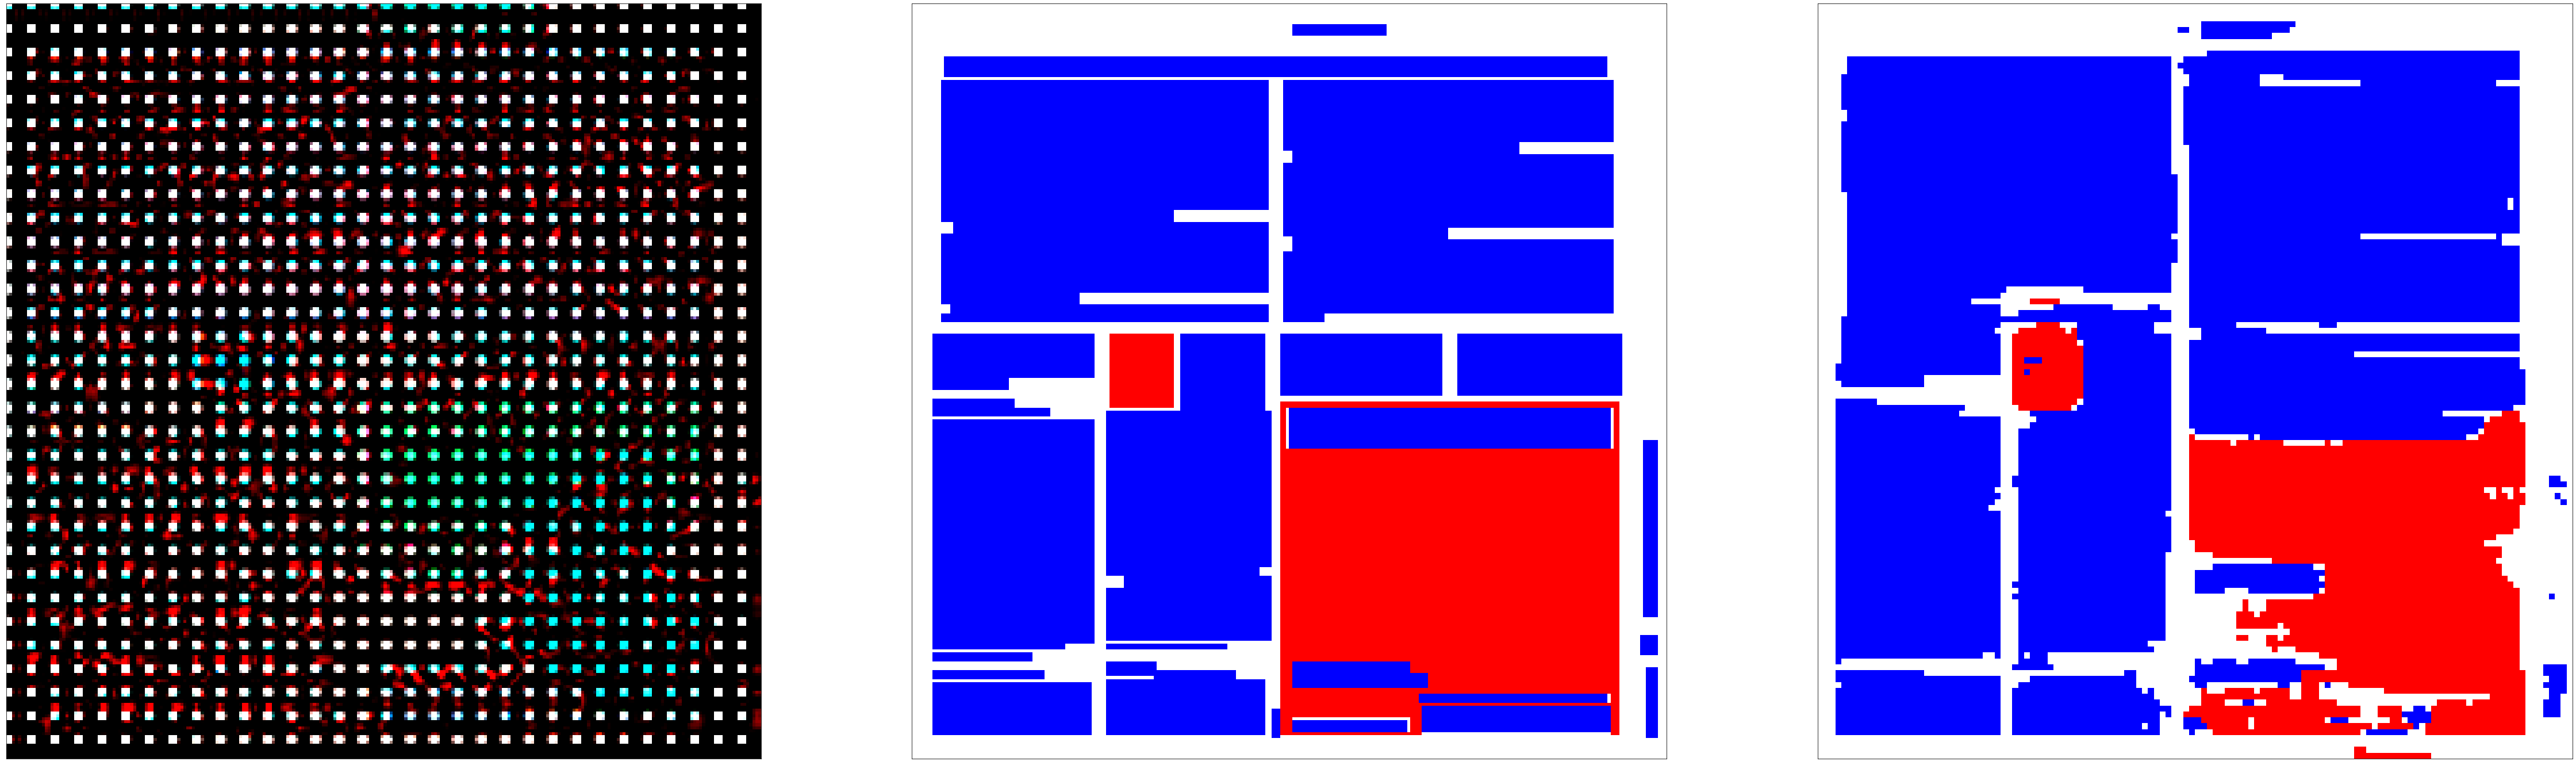

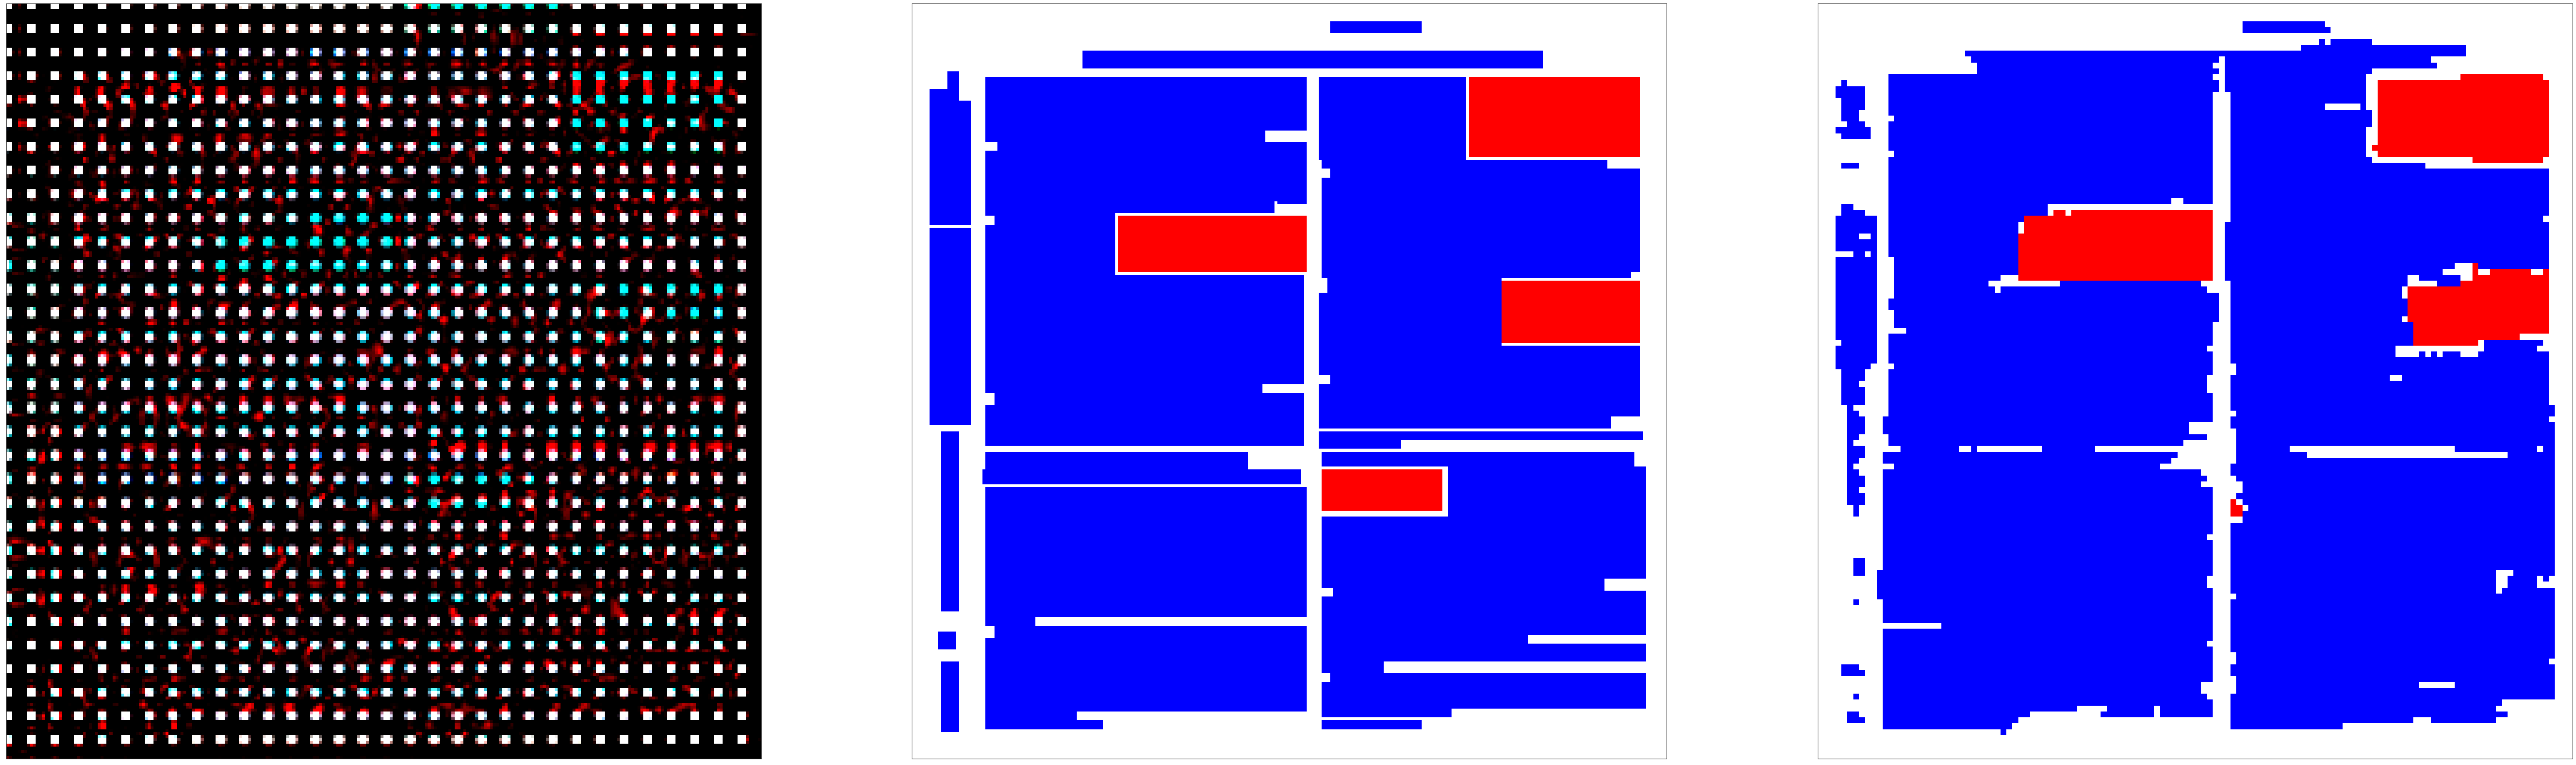

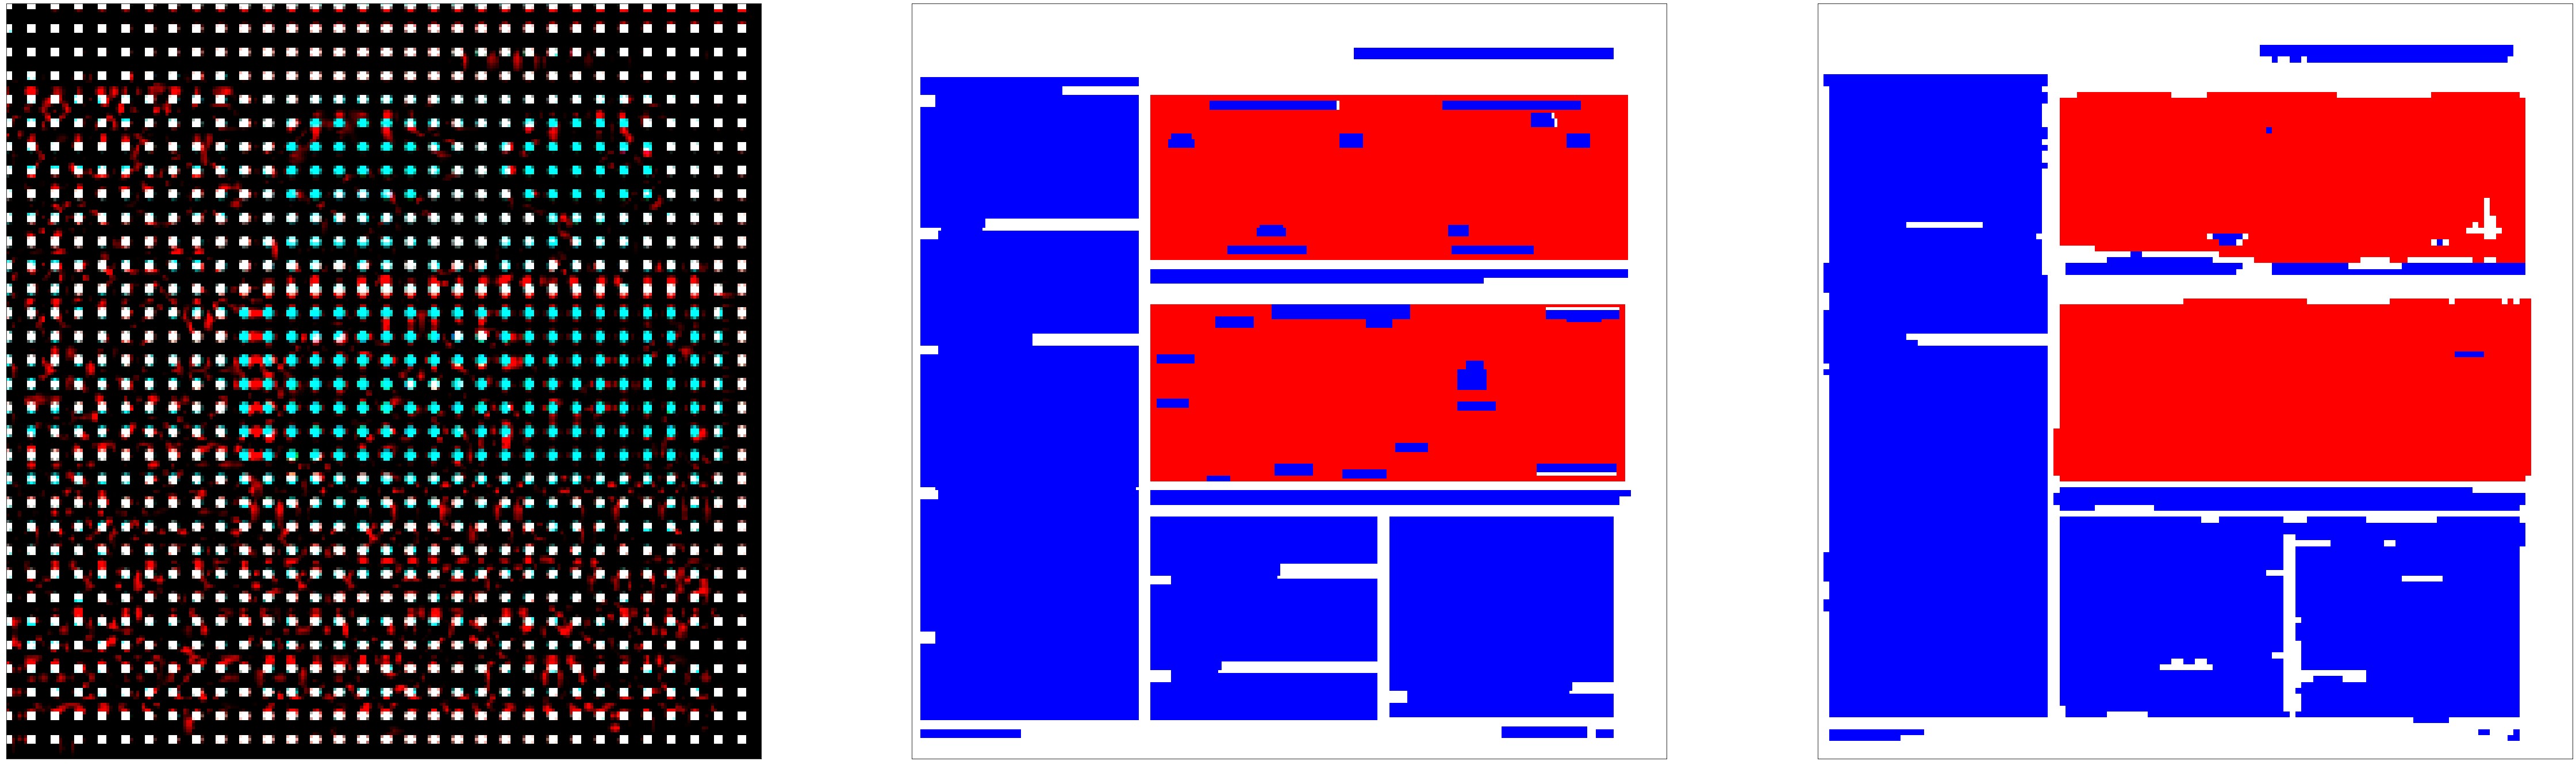

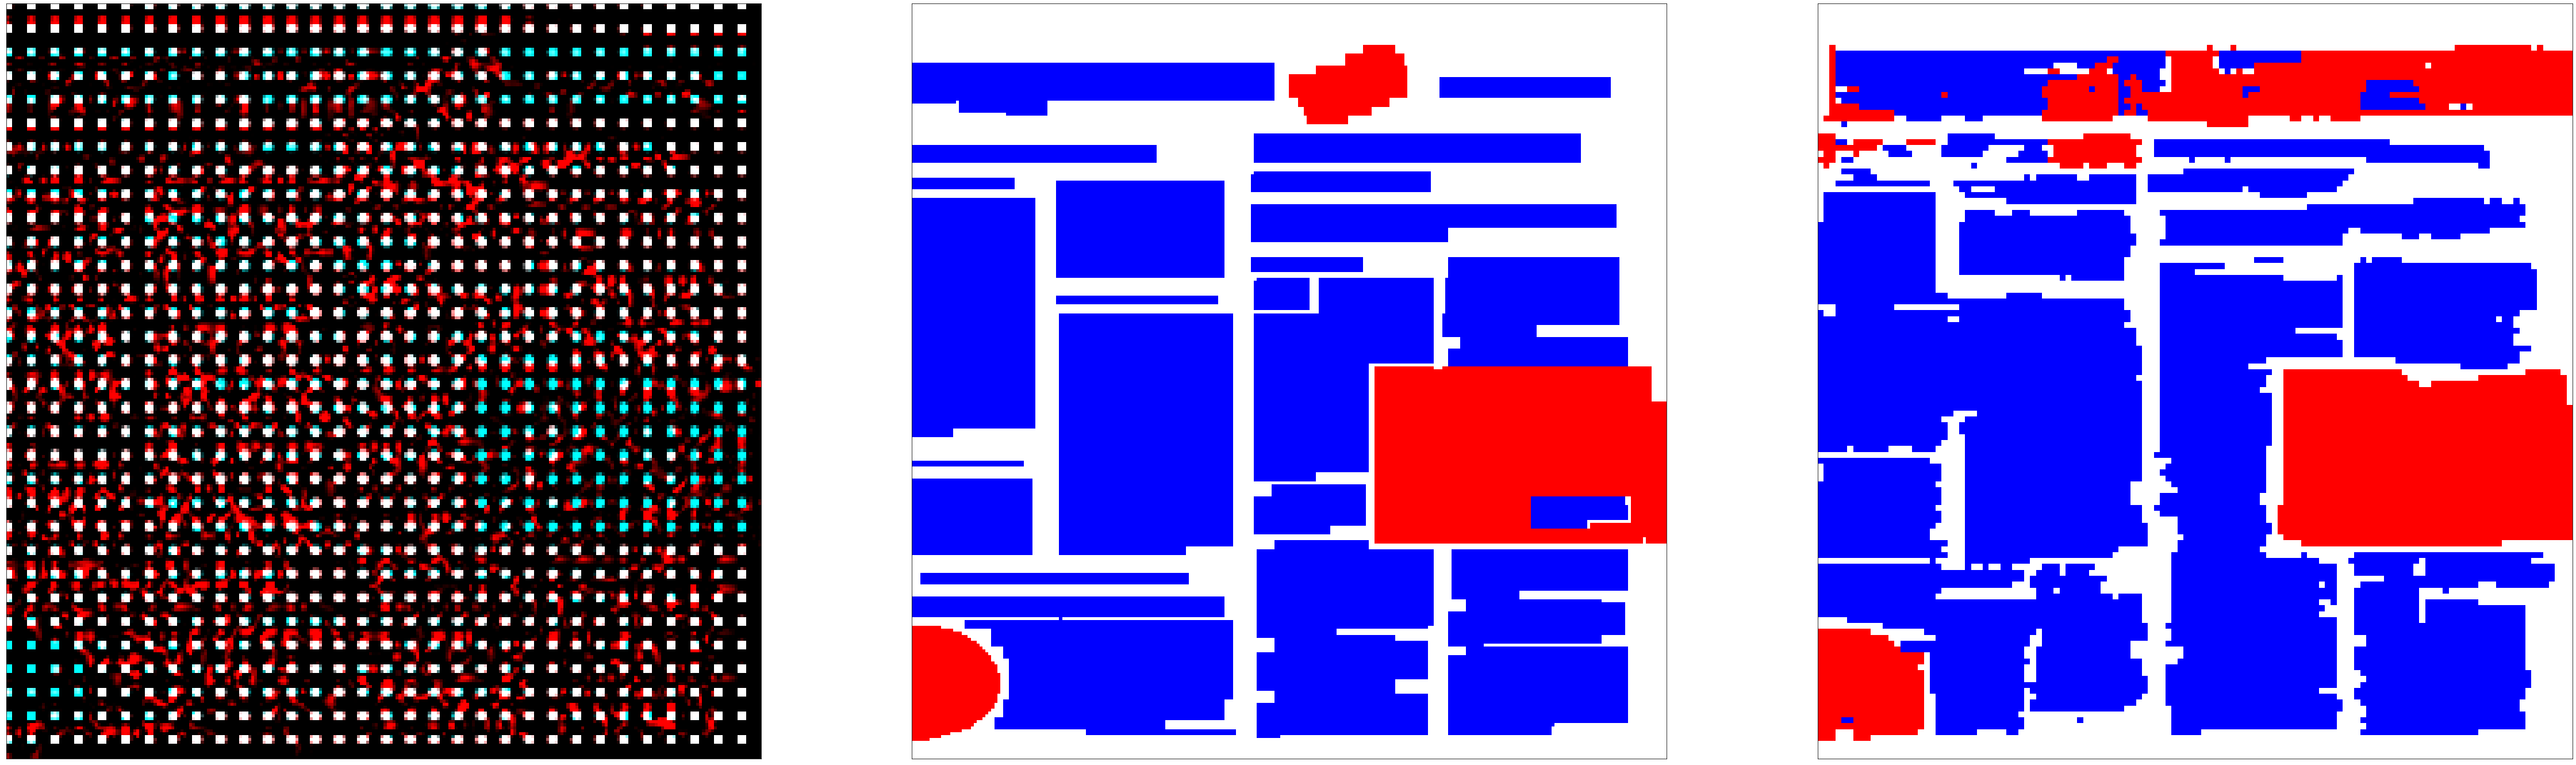

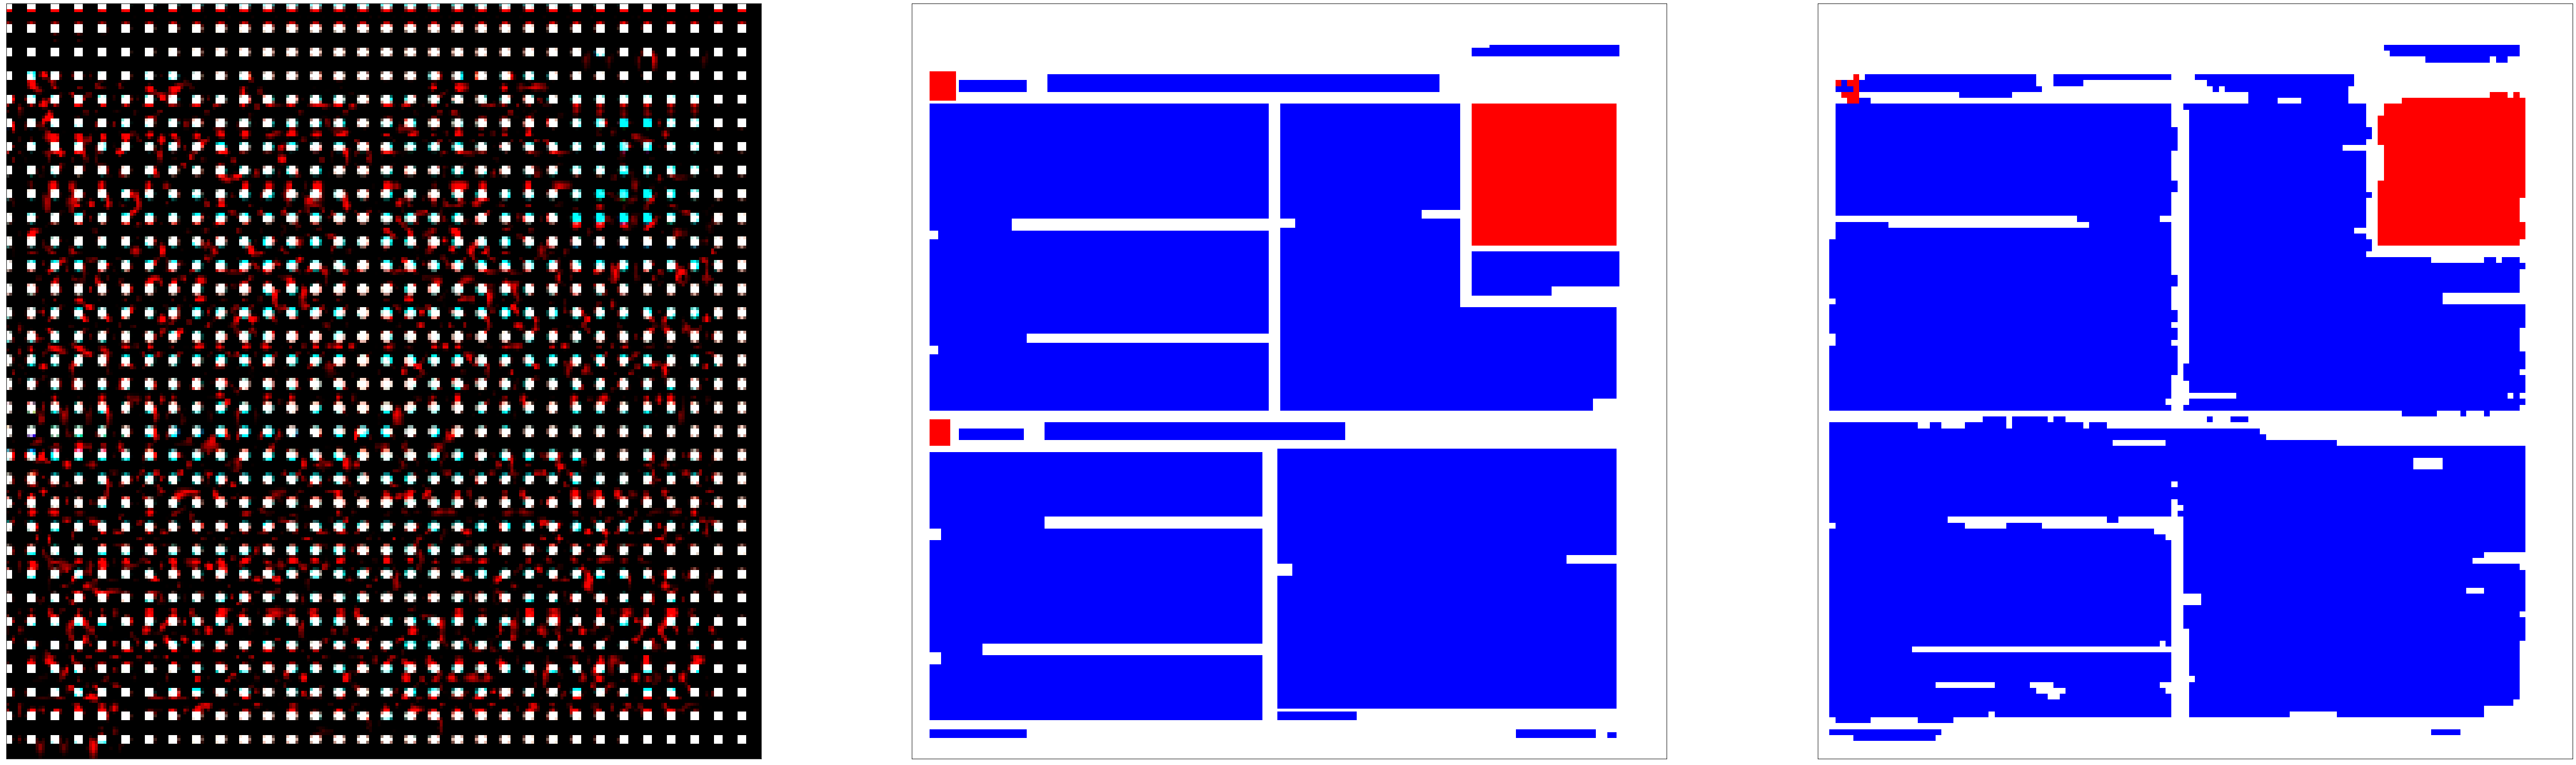

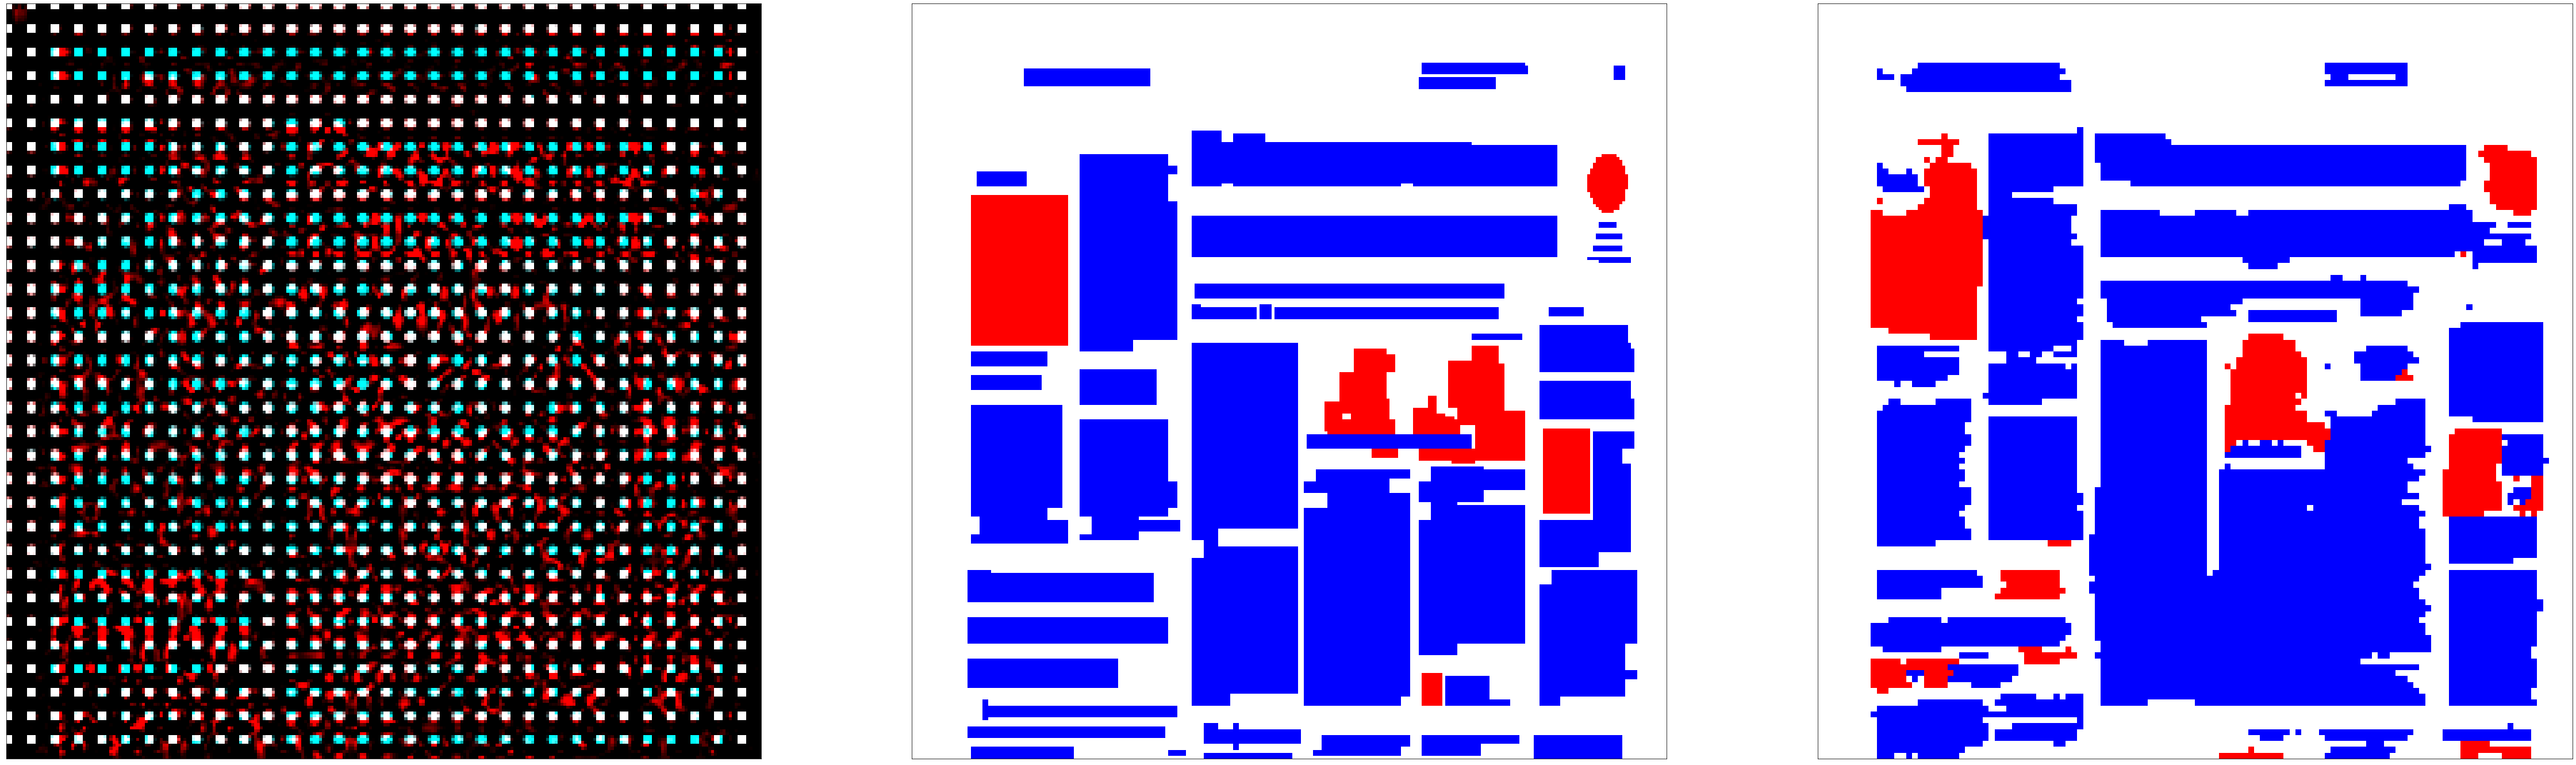

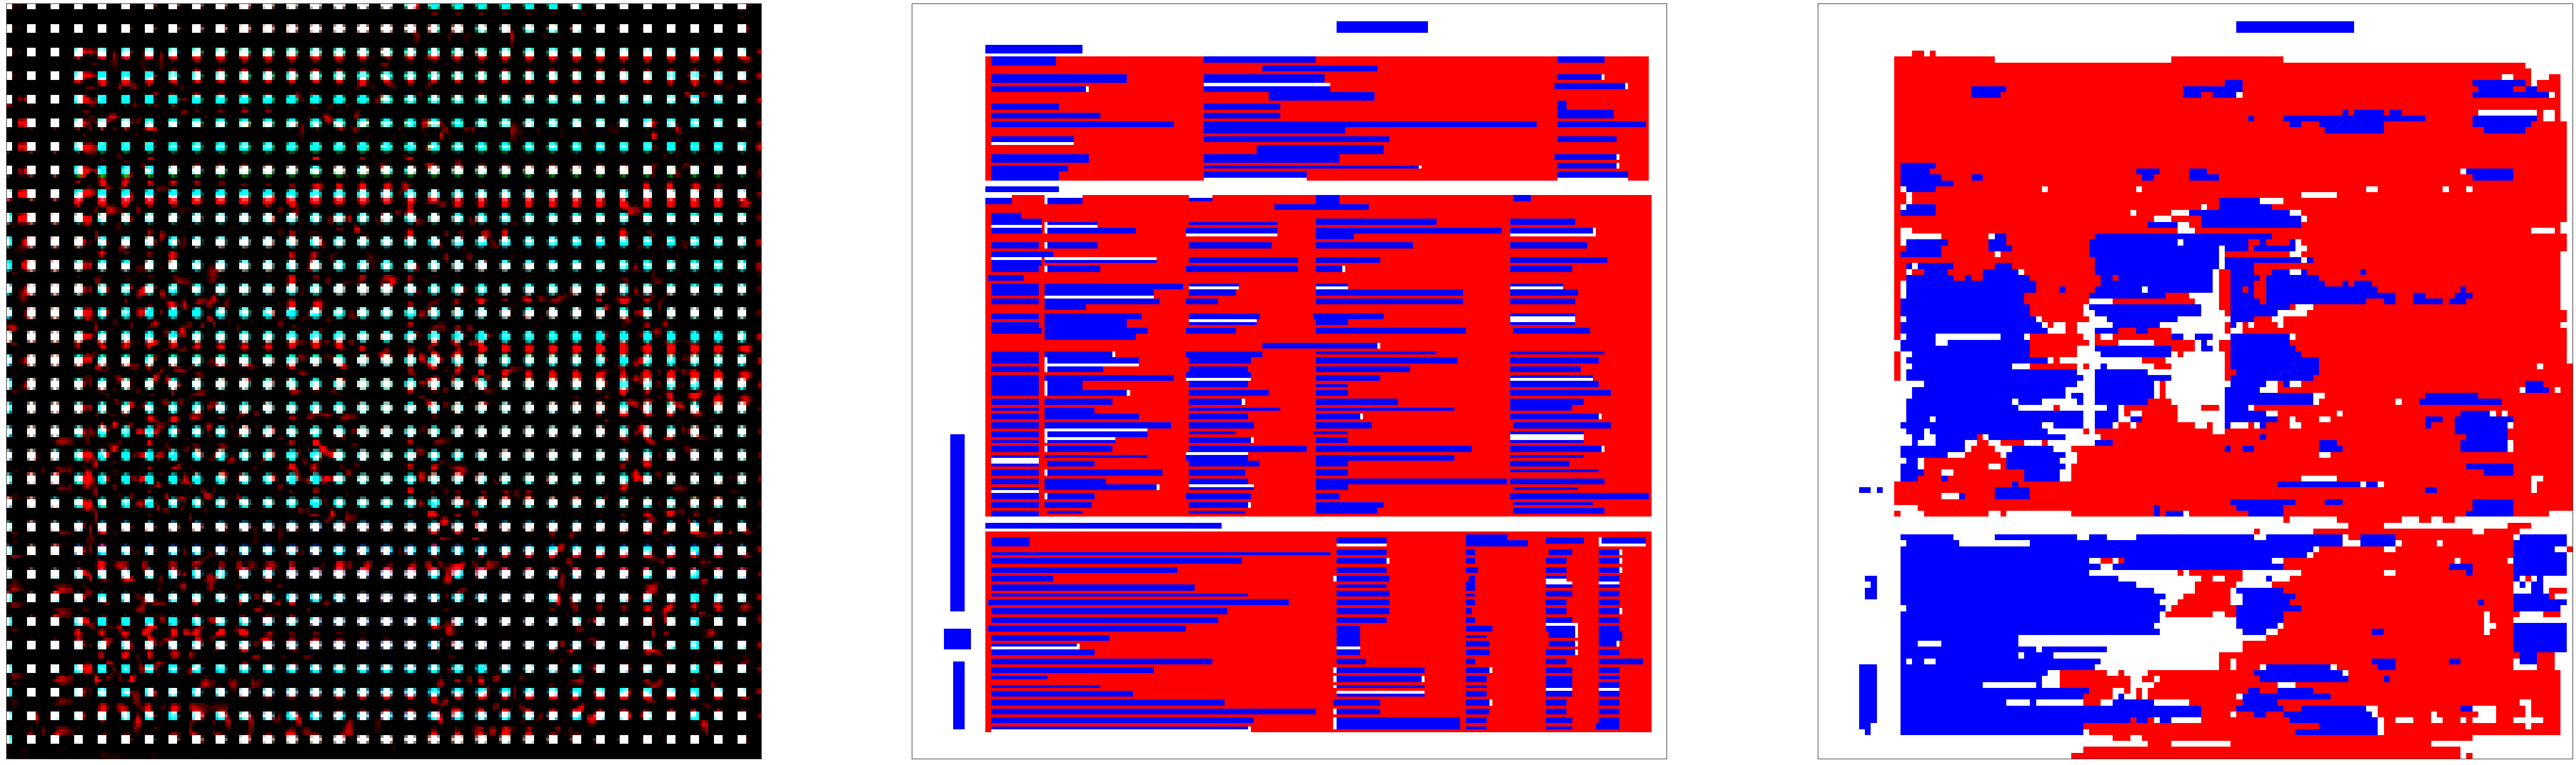

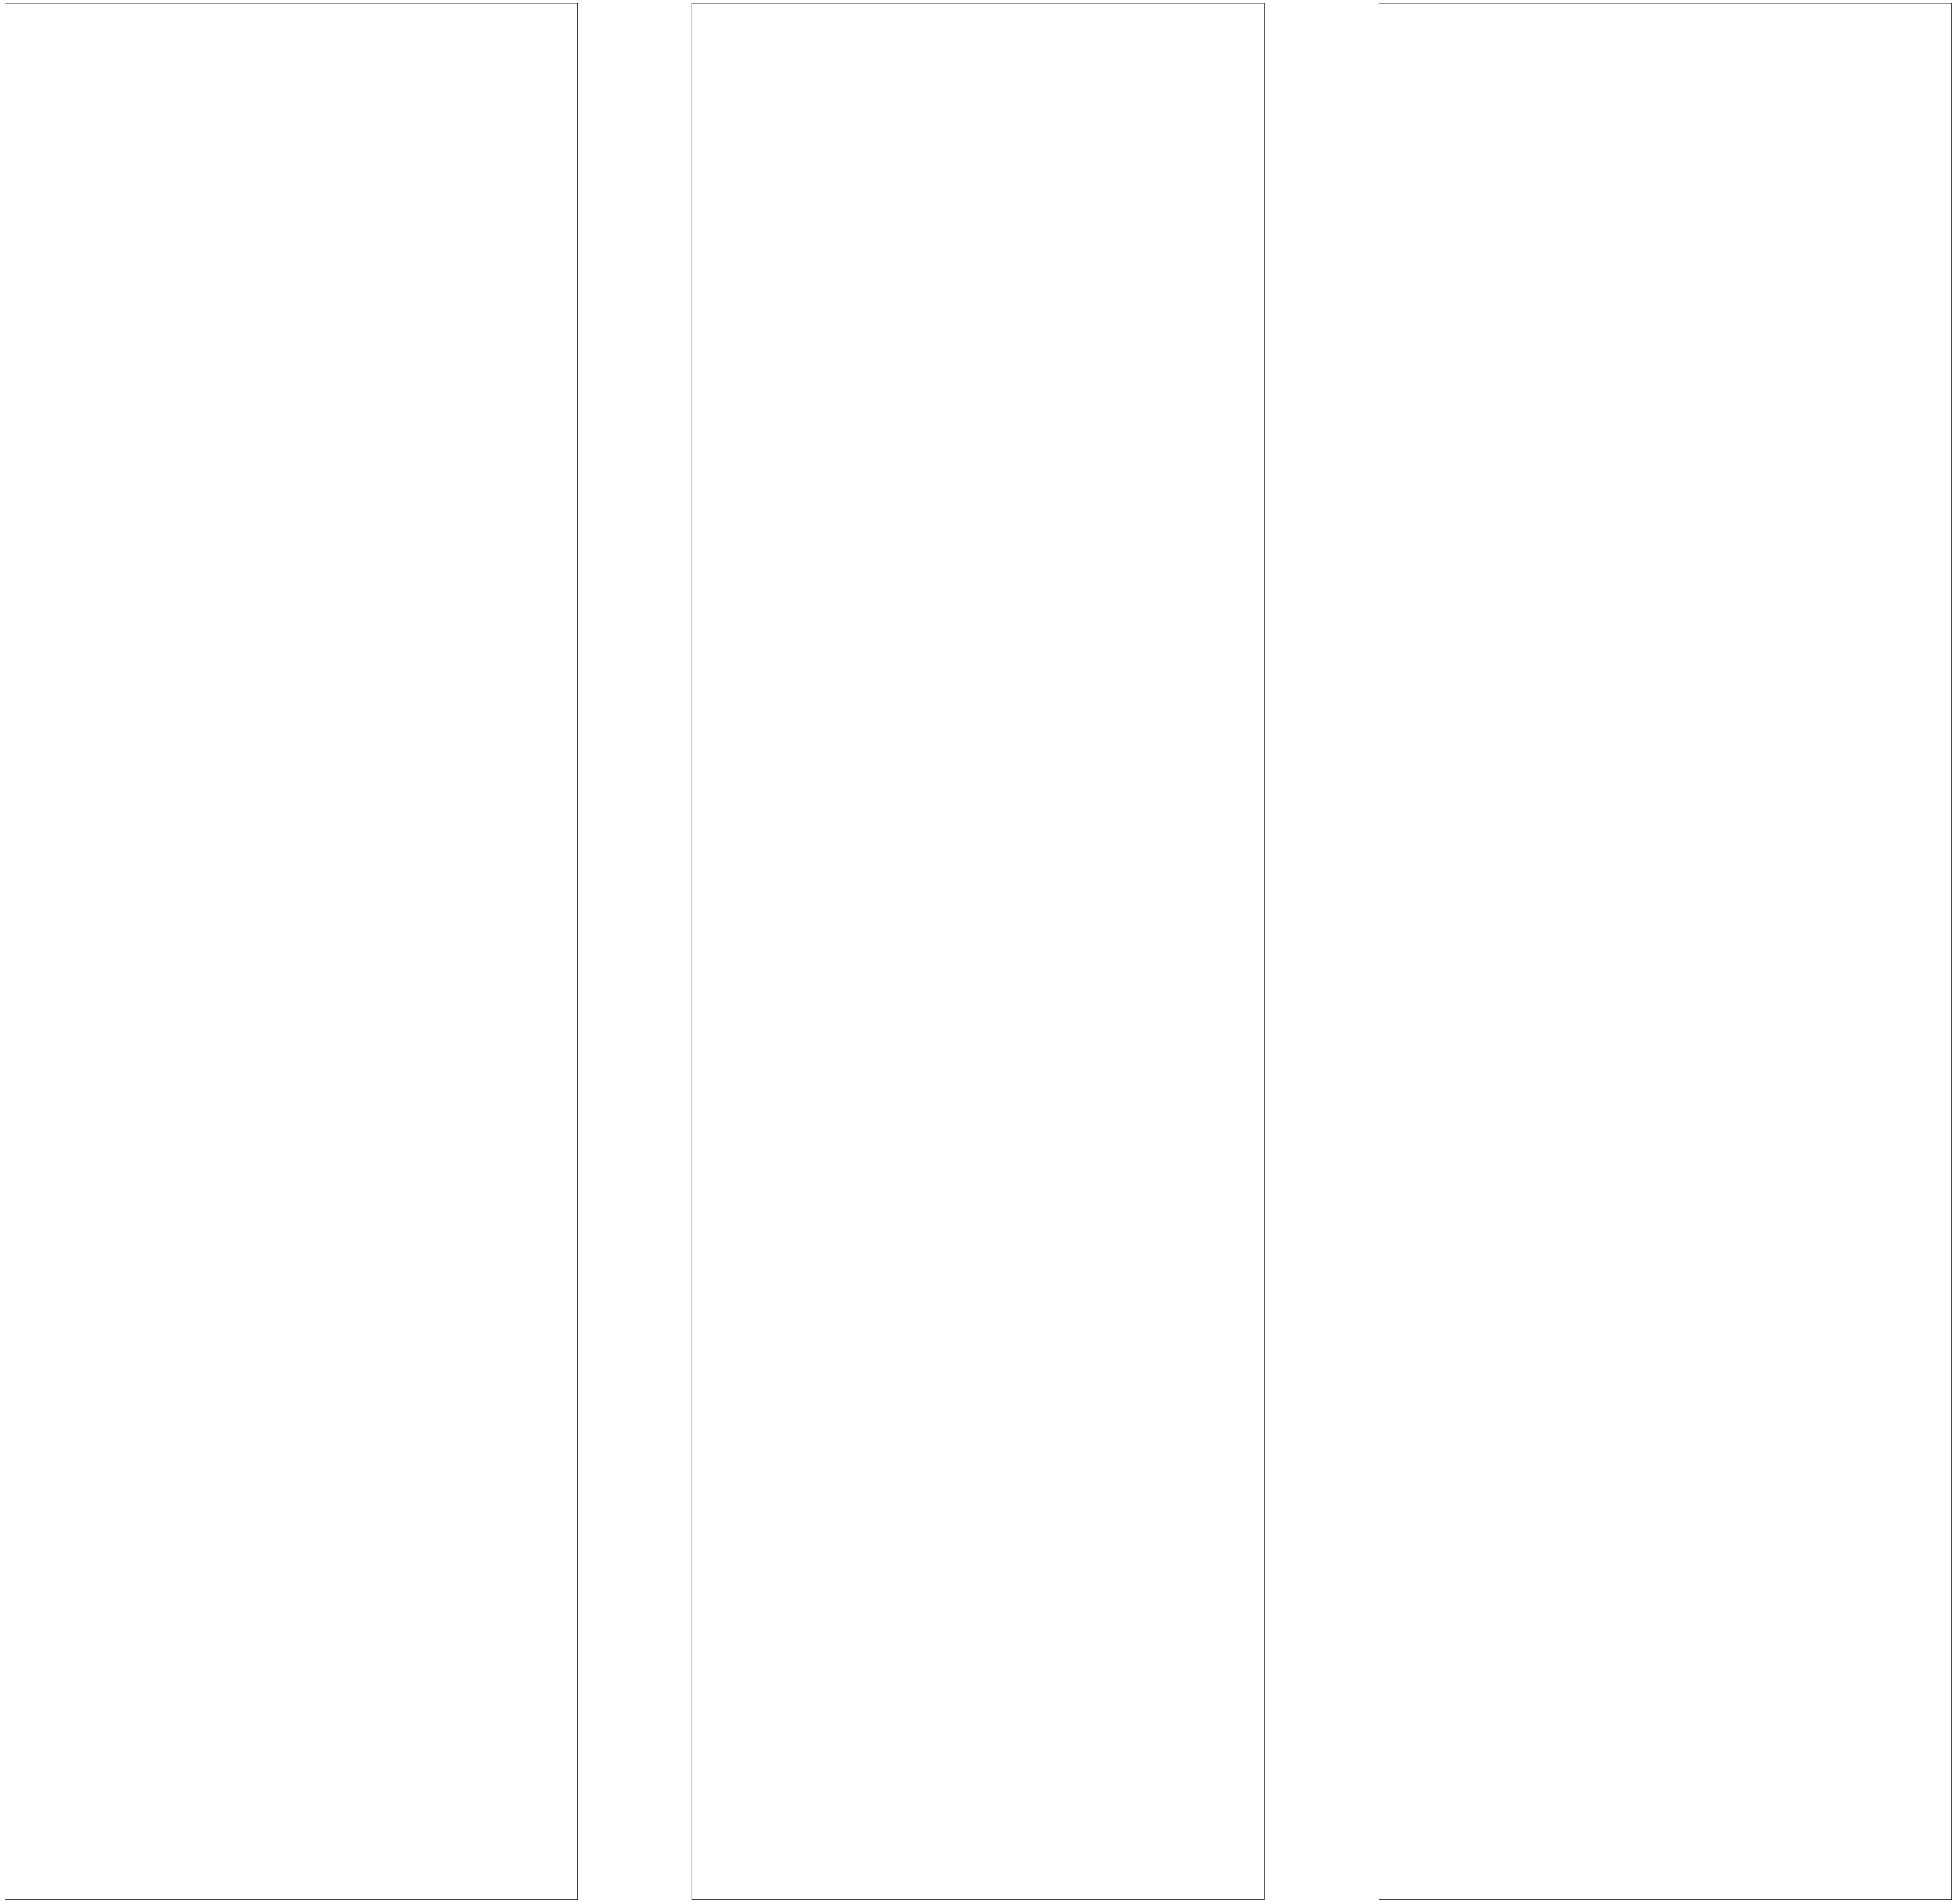

In [ ]:
y_hat = model_fcn.predict(x_test)
for i in range(6,25):
  offset = 0
  im_rows = 1
  im_cols = 3
  fig, ax = plt.subplots(offset + im_rows, im_cols, figsize=(80,80))
  ax[0].set_xticks([])
  ax[1].set_xticks([])
  ax[2].set_xticks([])
  ax[0].set_yticks([])
  ax[1].set_yticks([])
  ax[2].set_yticks([])
  ax[0].imshow(x_test[i,:,:,:])
  ax[1].imshow(output_debinarisation(y_test[i,:,:,:]))
  ax[2].imshow(output_debinarisation(y_hat[i,:,:,:]))

In [ ]:
y_hat = model_fcn.predict(x_test)

In [ ]:
average_precisions = [average_precision_score(y_test_i.reshape(-1),y_hat_i.reshape(-1)) for (y_test_i,y_hat_i) in zip(y_test,y_hat)]
print(np.mean(average_precisions))

0.8147864524342616
